In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Set working directory to '/n/groups/patel/shakson/aiready/'
import os
os.chdir("/home/shaksonisaac/CGM/mambatf/")

#LOAD Datasets
import pandas as pd
import io
from google.cloud import storage

_BUCKET_NAME = "cgmproject2025"

# Download dataset from GCS
client = storage.Client()
bucket = client.bucket(_BUCKET_NAME)
blob = bucket.blob('ai-ready/data/train_finaltimeseries_meal.feather')
data_bytes = blob.download_as_bytes()
train = pd.read_feather(io.BytesIO(data_bytes))


# Download test set:
client = storage.Client()
bucket = client.bucket(_BUCKET_NAME)
blob = bucket.blob('ai-ready/data/test_finaltimeseries_meal.feather')
data_bytes = blob.download_as_bytes()
test = pd.read_feather(io.BytesIO(data_bytes))

In [4]:
# Load Data
import os
import sys
import torch

#from TFT_pytorch import log_memory, create_tft_dataloaders, TFT_train
from scripts.mamba2_576_mes import create_tft_dataloaders, TFT_train, save_tft_to_gcs, load_tft_from_gcs

param_48 = {
    "dataset": {"context_length": 576, "horizon": 12, "batch_size": 32},
    "mamba_tft_init": {"mamba_depth": 4, "mamba_dropout": 0.2},
    "mamba_block": {
        "d_model": 128,
        "dropout": 0.2,
        "return_hidden_attn": False,
        "d_state": 128, #160,   # ↑ pour 48h (avant 128). Monte si sous-mémoire
        "d_conv": 8, #12,
        "expand": 4,
        "headdim": 64,
        "ngroups": 1      # 👈 idem
    },
    "mamba2_mes_runtime": {
        "mes_diag": True,
        "x_share_mode": "mean",
        "chunk_size": 128, #512,
        "dt_limit": (1e-3, 10.0),
        "learnable_init_states": True,
        "D": None
    },
    "checkpoint": {True}
}

training, val_dataloader, train_dataloader, validation = create_tft_dataloaders(train, horizon=12, context_length=576, batchsize=32)

tft = load_tft_from_gcs(model_name="Mamba2_12h_576c_MES", training_dataset=training)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tft = tft.to(device)   # <— this must move *every* sub‐module (including the Mamba blocks)  
tft.eval()  # Put model in evaluation mode

[2025-08-19 23:03:24.916425] 🚀 Start of Dataloader Creation
GPU Mem allocated: 0.00 GB | reserved: 0.00 GB


/home/shaksonisaac/miniconda3/envs/cgmall/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/home/shaksonisaac/miniconda3/envs/cgmall/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


Loaded TFT from gs://cgmproject2025/models/predictions/Mamba2_12h_576c_MES/


MambaTFT(
  	"attention_head_size":               8
  	"categorical_groups":                {}
  	"causal_attention":                  True
  	"dataset_parameters":                {'time_idx': 'ds', 'target': 'cgm_glucose', 'group_ids': ['participant_id'], 'weight': None, 'max_encoder_length': 576, 'min_encoder_length': 576, 'min_prediction_idx': np.int64(11), 'min_prediction_length': 12, 'max_prediction_length': 12, 'static_categoricals': ['participant_id', 'clinical_site', 'study_group'], 'static_reals': ['age'], 'time_varying_known_categoricals': ['sleep_stage'], 'time_varying_known_reals': ['ds', 'minute_of_day', 'tod_sin', 'tod_cos', 'activity_steps', 'calories_value', 'heartrate', 'oxygen_saturation', 'respiration_rate', 'stress_level', 'predmeal_flag'], 'time_varying_unknown_categoricals': None, 'time_varying_unknown_reals': ['cgm_glucose', 'cgm_lag_1', 'cgm_lag_3', 'cgm_lag_6', 'cgm_diff_lag_1', 'cgm_diff_lag_3', 'cgm_diff_lag_6', 'cgm_lagdiff_1_3', 'cgm_lagdiff_3_6', 'cgm_roll

In [5]:
participant_ids = train['participant_id'].unique()
print(participant_ids)

['1023' '1024' '1026' '1027' '1028' '1029' '1030' '1031' '1032' '1033'
 '1034' '1035' '1036' '1037' '1038' '1039' '1040' '1041' '1042' '1044'
 '1045' '1046' '1047' '1049' '1050' '1051' '1052' '1053' '1054' '1055'
 '1056' '1057' '1058' '1060' '1061' '1062' '1063' '1064' '1065' '1066'
 '1067' '1068' '1069' '1070' '1071' '1072' '1073' '1074' '1075' '1076'
 '1077' '1079' '1080' '1081' '1083' '1084' '1085' '1086' '1087' '1088'
 '1089' '1092' '1093' '1094' '1095' '1096' '1097' '1098' '1099' '1100'
 '1101' '1103' '1104' '1105' '1106' '1109' '1110' '1112' '1114' '1115'
 '1116' '1117' '1118' '1119' '1120' '1121' '1122' '1124' '1125' '1126'
 '1128' '1129' '1131' '1132' '1133' '1134' '1135' '1136' '1137' '1138'
 '1139' '1140' '1141' '1143' '1144' '1145' '1146' '1148' '1149' '1151'
 '1152' '1153' '1154' '1155' '1156' '1157' '1158' '1159' '1160' '1161'
 '1163' '1164' '1166' '1167' '1168' '1169' '1170' '1171' '1172' '1173'
 '1174' '1175' '1176' '1177' '1178' '1179' '1180' '1181' '1183' '1184'
 '1185

In [6]:
# Version 2: Use the new Scenario class verified under support/postivity assumptions
from counterfactual.scenariosv3 import Scenario, run_batch_nb

pids = participant_ids
print(pids)
scenarios = [Scenario(target_id=pid, covariate_name="heartrate", counterfact_std=+2.0,
                      baseline_mode="cont_fixed_z", baseline_z_value=0.0) for pid in pids]
print(scenarios)

all_results = run_batch_nb(train, training, tft, scenarios)

['1023' '1024' '1026' '1027' '1028' '1029' '1030' '1031' '1032' '1033'
 '1034' '1035' '1036' '1037' '1038' '1039' '1040' '1041' '1042' '1044'
 '1045' '1046' '1047' '1049' '1050' '1051' '1052' '1053' '1054' '1055'
 '1056' '1057' '1058' '1060' '1061' '1062' '1063' '1064' '1065' '1066'
 '1067' '1068' '1069' '1070' '1071' '1072' '1073' '1074' '1075' '1076'
 '1077' '1079' '1080' '1081' '1083' '1084' '1085' '1086' '1087' '1088'
 '1089' '1092' '1093' '1094' '1095' '1096' '1097' '1098' '1099' '1100'
 '1101' '1103' '1104' '1105' '1106' '1109' '1110' '1112' '1114' '1115'
 '1116' '1117' '1118' '1119' '1120' '1121' '1122' '1124' '1125' '1126'
 '1128' '1129' '1131' '1132' '1133' '1134' '1135' '1136' '1137' '1138'
 '1139' '1140' '1141' '1143' '1144' '1145' '1146' '1148' '1149' '1151'
 '1152' '1153' '1154' '1155' '1156' '1157' '1158' '1159' '1160' '1161'
 '1163' '1164' '1166' '1167' '1168' '1169' '1170' '1171' '1172' '1173'
 '1174' '1175' '1176' '1177' '1178' '1179' '1180' '1181' '1183' '1184'
 '1185

Scenarios:   0%|          | 0/741 [00:00<?, ?it/s, id=1023]/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:   0%|          | 1/741 [01:44<21:26:47, 104.33s/it, id=1024]

Dropped 1207/2246 windows (53.74%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:   0%|          | 2/741 [02:04<11:17:08, 54.98s/it, id=1026] 

Dropped 1232/2242 windows (54.95%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:   0%|          | 3/741 [02:22<7:47:40, 38.02s/it, id=1027] 

Dropped 1078/1964 windows (54.89%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:   1%|          | 4/741 [02:42<6:20:51, 31.01s/it, id=1028]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:   1%|          | 5/741 [03:03<5:32:53, 27.14s/it, id=1029]

Dropped 1232/2244 windows (54.90%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:   1%|          | 6/741 [03:23<5:04:00, 24.82s/it, id=1030]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:   1%|          | 7/741 [03:44<4:48:18, 23.57s/it, id=1031]

Dropped 1207/2246 windows (53.74%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:   1%|          | 8/741 [04:05<4:37:39, 22.73s/it, id=1032]

Dropped 1211/2246 windows (53.92%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:   1%|          | 9/741 [04:25<4:28:07, 21.98s/it, id=1033]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:   1%|▏         | 10/741 [04:46<4:21:33, 21.47s/it, id=1034]

Dropped 1232/2245 windows (54.88%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:   1%|▏         | 11/741 [05:06<4:19:08, 21.30s/it, id=1035]

Dropped 1208/2244 windows (53.83%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:   2%|▏         | 12/741 [05:27<4:15:12, 21.00s/it, id=1036]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:   2%|▏         | 13/741 [05:47<4:12:48, 20.84s/it, id=1037]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:   2%|▏         | 14/741 [06:07<4:10:00, 20.63s/it, id=1038]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:   2%|▏         | 15/741 [06:28<4:08:22, 20.53s/it, id=1039]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:   2%|▏         | 16/741 [06:47<4:03:16, 20.13s/it, id=1040]

Dropped 1078/2026 windows (53.21%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:   2%|▏         | 17/741 [07:07<4:03:03, 20.14s/it, id=1041]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:   2%|▏         | 18/741 [07:28<4:05:26, 20.37s/it, id=1042]

Dropped 1210/2246 windows (53.87%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:   3%|▎         | 19/741 [07:48<4:05:03, 20.36s/it, id=1044]

Dropped 1232/2245 windows (54.88%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:   3%|▎         | 20/741 [08:06<3:54:59, 19.55s/it, id=1045]

Dropped 978/1853 windows (52.78%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:   3%|▎         | 21/741 [08:26<3:57:52, 19.82s/it, id=1046]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:   3%|▎         | 22/741 [08:47<3:59:26, 19.98s/it, id=1047]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:   3%|▎         | 23/741 [09:07<4:00:50, 20.13s/it, id=1049]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:   3%|▎         | 24/741 [09:27<4:00:52, 20.16s/it, id=1050]

Dropped 1229/2246 windows (54.72%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:   3%|▎         | 25/741 [09:48<4:00:28, 20.15s/it, id=1051]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:   4%|▎         | 26/741 [10:08<3:59:46, 20.12s/it, id=1052]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:   4%|▎         | 27/741 [10:28<4:00:13, 20.19s/it, id=1053]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:   4%|▍         | 28/741 [10:49<4:02:51, 20.44s/it, id=1054]

Dropped 1207/2258 windows (53.45%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:   4%|▍         | 29/741 [11:09<4:02:11, 20.41s/it, id=1055]

Dropped 1244/2258 windows (55.09%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:   4%|▍         | 30/741 [11:30<4:03:27, 20.54s/it, id=1056]

Dropped 1212/2258 windows (53.68%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:   4%|▍         | 31/741 [11:48<3:52:20, 19.63s/it, id=1057]

Dropped 1048/1914 windows (54.75%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:   4%|▍         | 32/741 [12:08<3:53:57, 19.80s/it, id=1058]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:   4%|▍         | 33/741 [12:27<3:50:06, 19.50s/it, id=1060]

Dropped 1078/2001 windows (53.87%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:   5%|▍         | 34/741 [12:47<3:53:18, 19.80s/it, id=1061]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:   5%|▍         | 35/741 [13:08<3:54:56, 19.97s/it, id=1062]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:   5%|▍         | 36/741 [13:28<3:57:46, 20.24s/it, id=1063]

Dropped 1204/2246 windows (53.61%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:   5%|▍         | 37/741 [13:40<3:26:30, 17.60s/it, id=1064]

Dropped 616/1172 windows (52.56%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:   5%|▌         | 38/741 [14:01<3:37:38, 18.58s/it, id=1065]

Dropped 1206/2246 windows (53.70%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:   5%|▌         | 39/741 [14:21<3:43:08, 19.07s/it, id=1066]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:   5%|▌         | 40/741 [14:41<3:46:56, 19.42s/it, id=1067]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:   6%|▌         | 41/741 [15:02<3:50:19, 19.74s/it, id=1068]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:   6%|▌         | 42/741 [15:22<3:52:46, 19.98s/it, id=1069]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:   6%|▌         | 43/741 [15:43<3:53:48, 20.10s/it, id=1070]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:   6%|▌         | 44/741 [16:03<3:54:10, 20.16s/it, id=1071]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:   6%|▌         | 45/741 [16:24<3:56:16, 20.37s/it, id=1072]

Dropped 1205/2246 windows (53.65%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:   6%|▌         | 46/741 [16:44<3:55:57, 20.37s/it, id=1073]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:   6%|▋         | 47/741 [17:04<3:54:00, 20.23s/it, id=1074]

Dropped 1232/2232 windows (55.20%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:   6%|▋         | 48/741 [17:24<3:54:07, 20.27s/it, id=1075]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:   7%|▋         | 49/741 [17:45<3:56:06, 20.47s/it, id=1076]

Dropped 1208/2246 windows (53.78%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:   7%|▋         | 50/741 [18:06<3:55:25, 20.44s/it, id=1077]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:   7%|▋         | 51/741 [18:26<3:53:59, 20.35s/it, id=1079]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:   7%|▋         | 52/741 [18:46<3:53:26, 20.33s/it, id=1080]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:   7%|▋         | 53/741 [19:07<3:53:55, 20.40s/it, id=1081]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:   7%|▋         | 54/741 [19:27<3:52:51, 20.34s/it, id=1083]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:   7%|▋         | 55/741 [19:47<3:51:38, 20.26s/it, id=1084]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:   8%|▊         | 56/741 [20:07<3:52:09, 20.33s/it, id=1085]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:   8%|▊         | 57/741 [20:28<3:51:44, 20.33s/it, id=1086]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:   8%|▊         | 58/741 [20:48<3:51:58, 20.38s/it, id=1087]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:   8%|▊         | 59/741 [21:09<3:51:51, 20.40s/it, id=1088]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:   8%|▊         | 60/741 [21:29<3:50:24, 20.30s/it, id=1089]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:   8%|▊         | 61/741 [21:49<3:49:52, 20.28s/it, id=1092]

Dropped 1226/2246 windows (54.59%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:   8%|▊         | 62/741 [22:10<3:52:08, 20.51s/it, id=1093]

Dropped 1206/2245 windows (53.72%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:   9%|▊         | 63/741 [22:31<3:51:45, 20.51s/it, id=1094]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:   9%|▊         | 64/741 [22:51<3:50:34, 20.44s/it, id=1095]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:   9%|▉         | 65/741 [22:56<3:00:07, 15.99s/it, id=1096]

Dropped 308/557 windows (55.30%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:   9%|▉         | 66/741 [23:12<2:58:35, 15.87s/it, id=1097]

Dropped 924/1688 windows (54.74%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:   9%|▉         | 67/741 [23:32<3:12:49, 17.16s/it, id=1098]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:   9%|▉         | 68/741 [23:53<3:23:51, 18.18s/it, id=1099]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:   9%|▉         | 69/741 [24:14<3:32:57, 19.01s/it, id=1100]

Dropped 1206/2245 windows (53.72%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:   9%|▉         | 70/741 [24:34<3:37:35, 19.46s/it, id=1101]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  10%|▉         | 71/741 [24:55<3:40:04, 19.71s/it, id=1103]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  10%|▉         | 72/741 [25:15<3:41:08, 19.83s/it, id=1104]

Dropped 1232/2245 windows (54.88%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  10%|▉         | 73/741 [25:35<3:42:58, 20.03s/it, id=1105]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  10%|▉         | 74/741 [25:56<3:45:34, 20.29s/it, id=1106]

Dropped 1209/2246 windows (53.83%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  10%|█         | 75/741 [26:16<3:44:56, 20.26s/it, id=1109]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  10%|█         | 76/741 [26:37<3:45:31, 20.35s/it, id=1110]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  10%|█         | 77/741 [26:57<3:45:13, 20.35s/it, id=1112]

Dropped 1221/2246 windows (54.36%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  11%|█         | 78/741 [27:18<3:46:49, 20.53s/it, id=1114]

Dropped 1199/2242 windows (53.48%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  11%|█         | 79/741 [27:38<3:45:38, 20.45s/it, id=1115]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  11%|█         | 80/741 [27:59<3:44:59, 20.42s/it, id=1116]

Dropped 1232/2245 windows (54.88%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  11%|█         | 81/741 [28:20<3:46:27, 20.59s/it, id=1117]

Dropped 1203/2240 windows (53.71%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  11%|█         | 82/741 [28:41<3:47:25, 20.71s/it, id=1118]

Dropped 1207/2246 windows (53.74%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  11%|█         | 83/741 [29:01<3:46:20, 20.64s/it, id=1119]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  11%|█▏        | 84/741 [29:22<3:45:09, 20.56s/it, id=1120]

Dropped 1232/2245 windows (54.88%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  11%|█▏        | 85/741 [29:42<3:45:23, 20.61s/it, id=1121]

Dropped 1212/2246 windows (53.96%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  12%|█▏        | 86/741 [30:02<3:43:14, 20.45s/it, id=1122]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  12%|█▏        | 87/741 [30:23<3:42:47, 20.44s/it, id=1124]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  12%|█▏        | 88/741 [30:43<3:42:42, 20.46s/it, id=1125]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  12%|█▏        | 89/741 [31:04<3:44:11, 20.63s/it, id=1126]

Dropped 1203/2242 windows (53.66%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  12%|█▏        | 90/741 [31:25<3:42:57, 20.55s/it, id=1128]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  12%|█▏        | 91/741 [31:45<3:42:01, 20.49s/it, id=1129]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  12%|█▏        | 92/741 [32:05<3:41:18, 20.46s/it, id=1131]

Dropped 1220/2246 windows (54.32%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  13%|█▎        | 93/741 [32:26<3:40:24, 20.41s/it, id=1132]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  13%|█▎        | 94/741 [32:47<3:41:48, 20.57s/it, id=1133]

Dropped 1208/2245 windows (53.81%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  13%|█▎        | 95/741 [33:07<3:41:09, 20.54s/it, id=1134]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  13%|█▎        | 96/741 [33:28<3:41:59, 20.65s/it, id=1135]

Dropped 1210/2246 windows (53.87%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  13%|█▎        | 97/741 [33:48<3:39:53, 20.49s/it, id=1136]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  13%|█▎        | 98/741 [34:08<3:39:05, 20.44s/it, id=1137]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  13%|█▎        | 99/741 [34:29<3:40:09, 20.58s/it, id=1138]

Dropped 1206/2246 windows (53.70%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  13%|█▎        | 100/741 [34:50<3:39:29, 20.55s/it, id=1139]

Dropped 1232/2245 windows (54.88%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  14%|█▎        | 101/741 [35:10<3:39:04, 20.54s/it, id=1140]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  14%|█▍        | 102/741 [35:34<3:47:57, 21.41s/it, id=1141]

Dropped 1353/2527 windows (53.54%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  14%|█▍        | 103/741 [35:54<3:44:36, 21.12s/it, id=1143]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  14%|█▍        | 104/741 [36:15<3:42:04, 20.92s/it, id=1144]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  14%|█▍        | 105/741 [36:35<3:39:54, 20.75s/it, id=1145]

Dropped 1232/2245 windows (54.88%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  14%|█▍        | 106/741 [36:56<3:38:52, 20.68s/it, id=1146]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  14%|█▍        | 107/741 [37:16<3:37:25, 20.58s/it, id=1148]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  15%|█▍        | 108/741 [37:36<3:36:39, 20.54s/it, id=1149]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  15%|█▍        | 109/741 [37:57<3:35:44, 20.48s/it, id=1151]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  15%|█▍        | 110/741 [38:17<3:34:06, 20.36s/it, id=1152]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  15%|█▍        | 111/741 [38:33<3:22:12, 19.26s/it, id=1153]

Dropped 1045/1874 windows (55.76%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  15%|█▌        | 112/741 [38:54<3:24:32, 19.51s/it, id=1154]

Dropped 1232/2245 windows (54.88%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  15%|█▌        | 113/741 [39:14<3:25:55, 19.67s/it, id=1155]

Dropped 1232/2241 windows (54.98%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  15%|█▌        | 114/741 [39:34<3:27:53, 19.89s/it, id=1156]

Dropped 1220/2246 windows (54.32%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  16%|█▌        | 115/741 [39:54<3:28:56, 20.03s/it, id=1157]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  16%|█▌        | 116/741 [40:15<3:29:19, 20.09s/it, id=1158]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  16%|█▌        | 117/741 [40:35<3:29:48, 20.17s/it, id=1159]

Dropped 1202/2226 windows (54.00%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  16%|█▌        | 118/741 [40:55<3:27:49, 20.01s/it, id=1160]

Dropped 1177/2166 windows (54.34%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  16%|█▌        | 119/741 [41:15<3:28:07, 20.08s/it, id=1161]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  16%|█▌        | 120/741 [41:35<3:28:05, 20.11s/it, id=1163]

Dropped 1220/2234 windows (54.61%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  16%|█▋        | 121/741 [41:55<3:27:56, 20.12s/it, id=1164]

Dropped 1220/2234 windows (54.61%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  16%|█▋        | 122/741 [42:15<3:28:14, 20.18s/it, id=1166]

Dropped 1220/2234 windows (54.61%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  17%|█▋        | 123/741 [42:36<3:28:17, 20.22s/it, id=1167]

Dropped 1220/2233 windows (54.64%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  17%|█▋        | 124/741 [42:56<3:28:05, 20.24s/it, id=1168]

Dropped 1220/2234 windows (54.61%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  17%|█▋        | 125/741 [43:17<3:28:29, 20.31s/it, id=1169]

Dropped 1208/2234 windows (54.07%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  17%|█▋        | 126/741 [43:37<3:28:09, 20.31s/it, id=1170]

Dropped 1220/2234 windows (54.61%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  17%|█▋        | 127/741 [43:57<3:27:20, 20.26s/it, id=1171]

Dropped 1220/2234 windows (54.61%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  17%|█▋        | 128/741 [44:18<3:27:45, 20.33s/it, id=1172]

Dropped 1206/2234 windows (53.98%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  17%|█▋        | 129/741 [44:32<3:08:55, 18.52s/it, id=1173]

Dropped 758/1447 windows (52.38%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  18%|█▊        | 130/741 [44:52<3:13:37, 19.01s/it, id=1174]

Dropped 1220/2234 windows (54.61%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  18%|█▊        | 131/741 [45:12<3:17:03, 19.38s/it, id=1175]

Dropped 1217/2234 windows (54.48%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  18%|█▊        | 132/741 [45:32<3:19:23, 19.64s/it, id=1176]

Dropped 1232/2234 windows (55.15%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  18%|█▊        | 133/741 [45:52<3:20:01, 19.74s/it, id=1177]

Dropped 1232/2234 windows (55.15%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  18%|█▊        | 134/741 [46:13<3:21:53, 19.96s/it, id=1178]

Dropped 1218/2246 windows (54.23%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  18%|█▊        | 135/741 [46:33<3:22:35, 20.06s/it, id=1179]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  18%|█▊        | 136/741 [46:49<3:08:43, 18.72s/it, id=1180]

Dropped 924/1689 windows (54.71%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  18%|█▊        | 137/741 [47:10<3:15:15, 19.40s/it, id=1181]

Dropped 1207/2246 windows (53.74%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  19%|█▊        | 138/741 [47:30<3:16:51, 19.59s/it, id=1183]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  19%|█▉        | 139/741 [47:45<3:04:32, 18.39s/it, id=1184]

Dropped 789/1555 windows (50.74%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  19%|█▉        | 140/741 [48:06<3:09:59, 18.97s/it, id=1185]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  19%|█▉        | 141/741 [48:18<2:48:48, 16.88s/it, id=1186]

Dropped 694/1265 windows (54.86%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  19%|█▉        | 142/741 [48:39<3:00:34, 18.09s/it, id=1188]

Dropped 1204/2246 windows (53.61%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  19%|█▉        | 143/741 [48:59<3:08:32, 18.92s/it, id=1189]

Dropped 1206/2246 windows (53.70%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  19%|█▉        | 144/741 [49:20<3:12:16, 19.32s/it, id=1193]

Dropped 1232/2245 windows (54.88%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  20%|█▉        | 145/741 [49:40<3:15:01, 19.63s/it, id=1194]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  20%|█▉        | 146/741 [50:00<3:16:39, 19.83s/it, id=1195]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  20%|█▉        | 147/741 [50:20<3:15:45, 19.77s/it, id=1196]

Dropped 1217/2195 windows (55.44%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  20%|█▉        | 148/741 [50:41<3:18:39, 20.10s/it, id=1198]

Dropped 1204/2246 windows (53.61%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  20%|██        | 149/741 [51:01<3:18:51, 20.16s/it, id=1199]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  20%|██        | 150/741 [51:22<3:19:29, 20.25s/it, id=1200]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  20%|██        | 151/741 [51:42<3:19:09, 20.25s/it, id=1201]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  21%|██        | 152/741 [52:02<3:19:14, 20.30s/it, id=1202]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  21%|██        | 153/741 [52:23<3:18:52, 20.29s/it, id=1203]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  21%|██        | 154/741 [52:43<3:19:14, 20.37s/it, id=1204]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  21%|██        | 155/741 [53:04<3:20:26, 20.52s/it, id=1205]

Dropped 1203/2245 windows (53.59%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  21%|██        | 156/741 [53:30<3:35:08, 22.07s/it, id=1206]

Dropped 1540/2836 windows (54.30%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  21%|██        | 157/741 [53:50<3:29:02, 21.48s/it, id=1207]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  21%|██▏       | 158/741 [54:11<3:27:02, 21.31s/it, id=1208]

Dropped 1210/2246 windows (53.87%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  21%|██▏       | 159/741 [54:31<3:23:41, 21.00s/it, id=1209]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  22%|██▏       | 160/741 [54:52<3:22:08, 20.88s/it, id=1210]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  22%|██▏       | 161/741 [55:11<3:18:13, 20.51s/it, id=1211]

Dropped 1078/2057 windows (52.41%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  22%|██▏       | 162/741 [55:31<3:17:12, 20.44s/it, id=1212]

Dropped 1232/2245 windows (54.88%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  22%|██▏       | 163/741 [55:52<3:15:59, 20.35s/it, id=1213]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  22%|██▏       | 164/741 [56:11<3:14:01, 20.18s/it, id=1214]

Dropped 1232/2219 windows (55.52%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  22%|██▏       | 165/741 [56:32<3:15:41, 20.38s/it, id=1215]

Dropped 1204/2246 windows (53.61%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  22%|██▏       | 166/741 [56:53<3:14:58, 20.35s/it, id=1216]

Dropped 1232/2245 windows (54.88%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  23%|██▎       | 167/741 [57:13<3:15:12, 20.41s/it, id=1217]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  23%|██▎       | 168/741 [57:33<3:14:42, 20.39s/it, id=1218]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  23%|██▎       | 169/741 [57:54<3:15:52, 20.55s/it, id=1219]

Dropped 1206/2246 windows (53.70%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  23%|██▎       | 170/741 [58:15<3:15:25, 20.54s/it, id=1220]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  23%|██▎       | 171/741 [58:36<3:16:25, 20.68s/it, id=1221]

Dropped 1207/2246 windows (53.74%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  23%|██▎       | 172/741 [58:56<3:15:09, 20.58s/it, id=1222]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  23%|██▎       | 173/741 [59:17<3:15:55, 20.70s/it, id=1223]

Dropped 1208/2246 windows (53.78%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  23%|██▎       | 174/741 [59:37<3:14:28, 20.58s/it, id=1224]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  24%|██▎       | 175/741 [59:58<3:15:01, 20.67s/it, id=1225]

Dropped 1206/2246 windows (53.70%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  24%|██▍       | 176/741 [1:00:19<3:14:14, 20.63s/it, id=1226]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  24%|██▍       | 177/741 [1:00:39<3:13:09, 20.55s/it, id=1227]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  24%|██▍       | 178/741 [1:01:00<3:13:48, 20.66s/it, id=1228]

Dropped 1206/2246 windows (53.70%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  24%|██▍       | 179/741 [1:01:20<3:12:33, 20.56s/it, id=1229]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  24%|██▍       | 180/741 [1:01:41<3:13:04, 20.65s/it, id=1230]

Dropped 1204/2246 windows (53.61%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  24%|██▍       | 181/741 [1:02:02<3:11:40, 20.54s/it, id=1231]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  25%|██▍       | 182/741 [1:02:21<3:08:55, 20.28s/it, id=1232]

Dropped 1205/2183 windows (55.20%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  25%|██▍       | 183/741 [1:02:41<3:08:06, 20.23s/it, id=1233]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  25%|██▍       | 184/741 [1:03:02<3:09:42, 20.44s/it, id=1234]

Dropped 1209/2246 windows (53.83%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  25%|██▍       | 185/741 [1:03:23<3:09:01, 20.40s/it, id=1235]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  25%|██▌       | 186/741 [1:03:42<3:06:36, 20.17s/it, id=1236]

Dropped 1188/2167 windows (54.82%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  25%|██▌       | 187/741 [1:04:03<3:08:20, 20.40s/it, id=1237]

Dropped 1206/2246 windows (53.70%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  25%|██▌       | 188/741 [1:04:24<3:07:42, 20.37s/it, id=1238]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  26%|██▌       | 189/741 [1:04:44<3:08:53, 20.53s/it, id=1239]

Dropped 1210/2246 windows (53.87%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  26%|██▌       | 190/741 [1:05:05<3:08:23, 20.51s/it, id=1241]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  26%|██▌       | 191/741 [1:05:26<3:09:00, 20.62s/it, id=1242]

Dropped 1204/2245 windows (53.63%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  26%|██▌       | 192/741 [1:05:46<3:07:48, 20.53s/it, id=1243]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  26%|██▌       | 193/741 [1:06:06<3:06:56, 20.47s/it, id=1244]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  26%|██▌       | 194/741 [1:06:27<3:07:51, 20.61s/it, id=1245]

Dropped 1210/2246 windows (53.87%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  26%|██▋       | 195/741 [1:06:48<3:07:09, 20.57s/it, id=1246]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  26%|██▋       | 196/741 [1:07:08<3:06:00, 20.48s/it, id=1247]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  27%|██▋       | 197/741 [1:07:29<3:07:09, 20.64s/it, id=1248]

Dropped 1206/2245 windows (53.72%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  27%|██▋       | 198/741 [1:07:50<3:06:20, 20.59s/it, id=1249]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  27%|██▋       | 199/741 [1:08:10<3:05:24, 20.53s/it, id=1250]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  27%|██▋       | 200/741 [1:08:31<3:06:25, 20.68s/it, id=1251]

Dropped 1206/2245 windows (53.72%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  27%|██▋       | 201/741 [1:08:51<3:05:13, 20.58s/it, id=1252]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  27%|██▋       | 202/741 [1:09:12<3:04:08, 20.50s/it, id=1253]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  27%|██▋       | 203/741 [1:09:33<3:04:53, 20.62s/it, id=1254]

Dropped 1211/2246 windows (53.92%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  28%|██▊       | 204/741 [1:09:53<3:03:56, 20.55s/it, id=1255]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  28%|██▊       | 205/741 [1:10:14<3:03:38, 20.56s/it, id=1256]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  28%|██▊       | 206/741 [1:10:34<3:02:23, 20.46s/it, id=1257]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  28%|██▊       | 207/741 [1:10:54<3:01:02, 20.34s/it, id=1258]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  28%|██▊       | 208/741 [1:11:14<3:00:29, 20.32s/it, id=1259]

Dropped 1225/2246 windows (54.54%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  28%|██▊       | 209/741 [1:11:34<2:59:44, 20.27s/it, id=1260]

Dropped 1232/2245 windows (54.88%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  28%|██▊       | 210/741 [1:11:55<2:59:30, 20.28s/it, id=1261]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  28%|██▊       | 211/741 [1:12:15<2:59:49, 20.36s/it, id=1262]

Dropped 1217/2246 windows (54.19%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  29%|██▊       | 212/741 [1:12:35<2:59:22, 20.34s/it, id=1263]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  29%|██▊       | 213/741 [1:12:56<2:58:45, 20.31s/it, id=1264]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  29%|██▉       | 214/741 [1:13:16<2:58:01, 20.27s/it, id=1266]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  29%|██▉       | 215/741 [1:13:36<2:58:24, 20.35s/it, id=1267]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  29%|██▉       | 216/741 [1:13:57<2:59:23, 20.50s/it, id=1268]

Dropped 1206/2246 windows (53.70%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  29%|██▉       | 217/741 [1:14:17<2:58:27, 20.43s/it, id=1269]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  29%|██▉       | 218/741 [1:14:38<2:57:15, 20.34s/it, id=1270]

Dropped 1232/2244 windows (54.90%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  30%|██▉       | 219/741 [1:14:58<2:56:42, 20.31s/it, id=1271]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  30%|██▉       | 220/741 [1:15:19<2:58:12, 20.52s/it, id=1272]

Dropped 1207/2246 windows (53.74%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  30%|██▉       | 221/741 [1:15:39<2:56:59, 20.42s/it, id=1273]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  30%|██▉       | 222/741 [1:16:00<2:56:54, 20.45s/it, id=1274]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  30%|███       | 223/741 [1:16:20<2:55:52, 20.37s/it, id=1275]

Dropped 1232/2245 windows (54.88%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  30%|███       | 224/741 [1:16:40<2:54:45, 20.28s/it, id=1276]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  30%|███       | 225/741 [1:17:00<2:54:38, 20.31s/it, id=1277]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  30%|███       | 226/741 [1:17:19<2:49:50, 19.79s/it, id=1278]

Dropped 1078/1994 windows (54.06%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  31%|███       | 227/741 [1:17:39<2:50:51, 19.95s/it, id=1280]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  31%|███       | 228/741 [1:18:00<2:53:08, 20.25s/it, id=1281]

Dropped 1210/2246 windows (53.87%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  31%|███       | 229/741 [1:18:20<2:53:04, 20.28s/it, id=1283]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  31%|███       | 230/741 [1:18:41<2:53:32, 20.38s/it, id=1284]

Dropped 1078/2103 windows (51.26%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  31%|███       | 231/741 [1:19:01<2:52:32, 20.30s/it, id=1285]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  31%|███▏      | 232/741 [1:19:21<2:52:19, 20.31s/it, id=1286]

Dropped 1232/2245 windows (54.88%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  31%|███▏      | 233/741 [1:19:42<2:53:46, 20.53s/it, id=1287]

Dropped 1207/2246 windows (53.74%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  32%|███▏      | 234/741 [1:20:03<2:52:49, 20.45s/it, id=1289]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  32%|███▏      | 235/741 [1:20:23<2:53:15, 20.54s/it, id=1290]

Dropped 1213/2246 windows (54.01%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  32%|███▏      | 236/741 [1:20:40<2:43:09, 19.39s/it, id=1291]

Dropped 924/1748 windows (52.86%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  32%|███▏      | 237/741 [1:21:01<2:45:28, 19.70s/it, id=1292]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  32%|███▏      | 238/741 [1:21:22<2:48:26, 20.09s/it, id=1293]

Dropped 1208/2246 windows (53.78%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  32%|███▏      | 239/741 [1:21:42<2:48:52, 20.18s/it, id=1294]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  32%|███▏      | 240/741 [1:22:02<2:49:00, 20.24s/it, id=1295]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  33%|███▎      | 241/741 [1:22:23<2:50:32, 20.46s/it, id=1297]

Dropped 1208/2246 windows (53.78%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  33%|███▎      | 242/741 [1:22:44<2:49:40, 20.40s/it, id=1298]

Dropped 1232/2245 windows (54.88%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  33%|███▎      | 243/741 [1:23:04<2:48:51, 20.34s/it, id=1300]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  33%|███▎      | 244/741 [1:23:25<2:49:51, 20.51s/it, id=1302]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  33%|███▎      | 245/741 [1:23:46<2:50:35, 20.64s/it, id=1303]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  33%|███▎      | 246/741 [1:24:07<2:50:53, 20.71s/it, id=1304]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  33%|███▎      | 247/741 [1:24:20<2:33:14, 18.61s/it, id=1305]

Dropped 616/1239 windows (49.72%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  33%|███▎      | 248/741 [1:24:40<2:36:52, 19.09s/it, id=1306]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  34%|███▎      | 249/741 [1:25:01<2:41:10, 19.66s/it, id=1307]

Dropped 1211/2246 windows (53.92%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  34%|███▎      | 250/741 [1:25:22<2:42:21, 19.84s/it, id=1308]

Dropped 1228/2245 windows (54.70%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  34%|███▍      | 251/741 [1:25:42<2:42:48, 19.94s/it, id=1309]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  34%|███▍      | 252/741 [1:26:03<2:44:55, 20.24s/it, id=1310]

Dropped 1209/2246 windows (53.83%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  34%|███▍      | 253/741 [1:26:23<2:44:50, 20.27s/it, id=1311]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  34%|███▍      | 254/741 [1:26:43<2:44:24, 20.26s/it, id=1312]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  34%|███▍      | 255/741 [1:27:04<2:43:57, 20.24s/it, id=1313]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  35%|███▍      | 256/741 [1:27:23<2:42:22, 20.09s/it, id=1314]

Dropped 1201/2191 windows (54.82%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  35%|███▍      | 257/741 [1:27:44<2:42:22, 20.13s/it, id=1315]

Dropped 1231/2246 windows (54.81%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  35%|███▍      | 258/741 [1:28:04<2:42:08, 20.14s/it, id=1316]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  35%|███▍      | 259/741 [1:28:24<2:42:23, 20.21s/it, id=1317]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  35%|███▌      | 260/741 [1:28:45<2:43:23, 20.38s/it, id=1318]

Dropped 1212/2246 windows (53.96%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  35%|███▌      | 261/741 [1:29:06<2:44:15, 20.53s/it, id=1320]

Dropped 1206/2246 windows (53.70%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  35%|███▌      | 262/741 [1:29:27<2:45:05, 20.68s/it, id=1321]

Dropped 1204/2243 windows (53.68%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  35%|███▌      | 263/741 [1:29:47<2:43:49, 20.56s/it, id=1322]

Dropped 1230/2246 windows (54.76%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  36%|███▌      | 264/741 [1:30:07<2:42:19, 20.42s/it, id=1323]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  36%|███▌      | 265/741 [1:30:27<2:41:43, 20.39s/it, id=1324]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  36%|███▌      | 266/741 [1:30:32<2:03:07, 15.55s/it, id=1325]

Dropped 255/433 windows (58.89%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  36%|███▌      | 267/741 [1:30:53<2:15:31, 17.16s/it, id=1326]

Dropped 1204/2245 windows (53.63%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  36%|███▌      | 268/741 [1:31:13<2:22:49, 18.12s/it, id=1327]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  36%|███▋      | 269/741 [1:31:33<2:27:18, 18.72s/it, id=1328]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  36%|███▋      | 270/741 [1:31:51<2:24:56, 18.46s/it, id=1329]

Dropped 928/1801 windows (51.53%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  37%|███▋      | 271/741 [1:32:11<2:28:25, 18.95s/it, id=1330]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  37%|███▋      | 272/741 [1:32:31<2:30:46, 19.29s/it, id=1331]

Dropped 1232/2245 windows (54.88%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  37%|███▋      | 273/741 [1:32:52<2:33:05, 19.63s/it, id=1332]

Dropped 1220/2246 windows (54.32%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  37%|███▋      | 274/741 [1:33:12<2:34:09, 19.81s/it, id=1333]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  37%|███▋      | 275/741 [1:33:32<2:34:22, 19.88s/it, id=1334]

Dropped 1232/2244 windows (54.90%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  37%|███▋      | 276/741 [1:33:53<2:36:31, 20.20s/it, id=1335]

Dropped 1204/2246 windows (53.61%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  37%|███▋      | 277/741 [1:34:13<2:36:34, 20.25s/it, id=1336]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  38%|███▊      | 278/741 [1:34:33<2:36:19, 20.26s/it, id=1337]

Dropped 1228/2244 windows (54.72%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  38%|███▊      | 279/741 [1:34:54<2:35:35, 20.21s/it, id=1339]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  38%|███▊      | 280/741 [1:35:14<2:35:26, 20.23s/it, id=1340]

Dropped 1232/2245 windows (54.88%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  38%|███▊      | 281/741 [1:35:35<2:36:38, 20.43s/it, id=1341]

Dropped 1205/2245 windows (53.67%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  38%|███▊      | 282/741 [1:35:55<2:35:55, 20.38s/it, id=1344]

Dropped 1230/2246 windows (54.76%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  38%|███▊      | 283/741 [1:36:15<2:35:29, 20.37s/it, id=1345]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  38%|███▊      | 284/741 [1:36:35<2:34:27, 20.28s/it, id=1346]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  38%|███▊      | 285/741 [1:36:56<2:35:35, 20.47s/it, id=1347]

Dropped 1211/2246 windows (53.92%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  39%|███▊      | 286/741 [1:37:17<2:34:38, 20.39s/it, id=1348]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  39%|███▊      | 287/741 [1:37:37<2:34:16, 20.39s/it, id=1349]

Dropped 1232/2244 windows (54.90%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  39%|███▉      | 288/741 [1:37:57<2:33:30, 20.33s/it, id=1350]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  39%|███▉      | 289/741 [1:38:17<2:33:17, 20.35s/it, id=1351]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  39%|███▉      | 290/741 [1:38:29<2:13:30, 17.76s/it, id=1352]

Dropped 713/1277 windows (55.83%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  39%|███▉      | 291/741 [1:38:50<2:18:58, 18.53s/it, id=1353]

Dropped 1230/2246 windows (54.76%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  39%|███▉      | 292/741 [1:39:07<2:15:26, 18.10s/it, id=1354]

Dropped 924/1766 windows (52.32%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  40%|███▉      | 293/741 [1:39:27<2:20:15, 18.78s/it, id=1355]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  40%|███▉      | 294/741 [1:39:47<2:22:53, 19.18s/it, id=1356]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  40%|███▉      | 295/741 [1:40:07<2:24:35, 19.45s/it, id=1357]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  40%|███▉      | 296/741 [1:40:27<2:26:03, 19.69s/it, id=1359]

Dropped 1231/2246 windows (54.81%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  40%|████      | 297/741 [1:40:48<2:28:28, 20.06s/it, id=1361]

Dropped 1204/2246 windows (53.61%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  40%|████      | 298/741 [1:41:01<2:11:03, 17.75s/it, id=1362]

Dropped 732/1327 windows (55.16%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  40%|████      | 299/741 [1:41:22<2:17:57, 18.73s/it, id=1363]

Dropped 1210/2246 windows (53.87%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  40%|████      | 300/741 [1:41:42<2:21:33, 19.26s/it, id=1364]

Dropped 1232/2245 windows (54.88%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  41%|████      | 301/741 [1:42:03<2:23:30, 19.57s/it, id=1365]

Dropped 1232/2245 windows (54.88%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  41%|████      | 302/741 [1:42:23<2:24:20, 19.73s/it, id=1366]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  41%|████      | 303/741 [1:42:44<2:26:48, 20.11s/it, id=1367]

Dropped 1207/2246 windows (53.74%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  41%|████      | 304/741 [1:43:04<2:27:18, 20.22s/it, id=1368]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  41%|████      | 305/741 [1:43:25<2:28:35, 20.45s/it, id=1372]

Dropped 1208/2246 windows (53.78%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  41%|████▏     | 306/741 [1:43:45<2:28:07, 20.43s/it, id=1374]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  41%|████▏     | 307/741 [1:44:06<2:27:19, 20.37s/it, id=1376]

Dropped 1228/2246 windows (54.67%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  42%|████▏     | 308/741 [1:44:26<2:26:49, 20.34s/it, id=1377]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  42%|████▏     | 309/741 [1:44:46<2:25:47, 20.25s/it, id=1379]

Dropped 1232/2245 windows (54.88%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  42%|████▏     | 310/741 [1:45:07<2:25:58, 20.32s/it, id=1380]

Dropped 1216/2245 windows (54.16%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  42%|████▏     | 311/741 [1:45:27<2:25:41, 20.33s/it, id=1381]

Dropped 1105/2110 windows (52.37%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  42%|████▏     | 312/741 [1:45:48<2:26:45, 20.53s/it, id=1383]

Dropped 1209/2246 windows (53.83%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  42%|████▏     | 313/741 [1:46:09<2:26:59, 20.61s/it, id=1384]

Dropped 1185/2219 windows (53.40%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  42%|████▏     | 314/741 [1:46:29<2:25:55, 20.50s/it, id=1385]

Dropped 1231/2245 windows (54.83%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  43%|████▎     | 315/741 [1:46:49<2:24:39, 20.37s/it, id=4009]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  43%|████▎     | 316/741 [1:47:09<2:23:43, 20.29s/it, id=4019]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  43%|████▎     | 317/741 [1:47:29<2:23:39, 20.33s/it, id=4022]

Dropped 1220/2246 windows (54.32%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  43%|████▎     | 318/741 [1:47:50<2:24:34, 20.51s/it, id=4026]

Dropped 1199/2245 windows (53.41%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  43%|████▎     | 319/741 [1:48:11<2:24:13, 20.51s/it, id=4030]

Dropped 1232/2244 windows (54.90%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  43%|████▎     | 320/741 [1:48:31<2:23:32, 20.46s/it, id=4033]

Dropped 1232/2244 windows (54.90%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  43%|████▎     | 321/741 [1:48:52<2:22:59, 20.43s/it, id=4035]

Dropped 1244/2258 windows (55.09%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  43%|████▎     | 322/741 [1:49:12<2:22:29, 20.40s/it, id=4037]

Dropped 1244/2258 windows (55.09%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  44%|████▎     | 323/741 [1:49:25<2:07:42, 18.33s/it, id=4041]

Dropped 766/1419 windows (53.98%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  44%|████▎     | 324/741 [1:49:46<2:11:06, 18.86s/it, id=4042]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  44%|████▍     | 325/741 [1:50:06<2:13:39, 19.28s/it, id=4044]

Dropped 1244/2258 windows (55.09%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  44%|████▍     | 326/741 [1:50:27<2:16:43, 19.77s/it, id=4046]

Dropped 1202/2246 windows (53.52%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  44%|████▍     | 327/741 [1:50:48<2:18:53, 20.13s/it, id=4051]

Dropped 1196/2246 windows (53.25%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  44%|████▍     | 328/741 [1:51:09<2:20:05, 20.35s/it, id=4054]

Dropped 1215/2256 windows (53.86%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  44%|████▍     | 329/741 [1:51:29<2:19:38, 20.34s/it, id=4058]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  45%|████▍     | 330/741 [1:51:50<2:20:33, 20.52s/it, id=4104]

Dropped 1193/2243 windows (53.19%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  45%|████▍     | 331/741 [1:52:10<2:19:54, 20.47s/it, id=4105]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  45%|████▍     | 332/741 [1:52:30<2:19:03, 20.40s/it, id=4106]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  45%|████▍     | 333/741 [1:52:51<2:19:17, 20.48s/it, id=4107]

Dropped 1215/2246 windows (54.10%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  45%|████▌     | 334/741 [1:53:04<2:03:05, 18.15s/it, id=4109]

Dropped 770/1384 windows (55.64%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  45%|████▌     | 335/741 [1:53:24<2:07:03, 18.78s/it, id=4111]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  45%|████▌     | 336/741 [1:53:44<2:09:01, 19.12s/it, id=4112]

Dropped 1174/2176 windows (53.95%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  45%|████▌     | 337/741 [1:54:04<2:10:46, 19.42s/it, id=4115]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  46%|████▌     | 338/741 [1:54:25<2:13:06, 19.82s/it, id=4116]

Dropped 1213/2246 windows (54.01%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  46%|████▌     | 339/741 [1:54:45<2:13:28, 19.92s/it, id=4117]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  46%|████▌     | 340/741 [1:55:05<2:13:34, 19.99s/it, id=4118]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  46%|████▌     | 341/741 [1:55:25<2:13:54, 20.09s/it, id=4119]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  46%|████▌     | 342/741 [1:55:45<2:13:16, 20.04s/it, id=4120]

Dropped 1232/2230 windows (55.25%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  46%|████▋     | 343/741 [1:56:06<2:13:19, 20.10s/it, id=4122]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  46%|████▋     | 344/741 [1:56:27<2:14:47, 20.37s/it, id=4123]

Dropped 1205/2244 windows (53.70%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  47%|████▋     | 345/741 [1:56:47<2:14:47, 20.42s/it, id=4125]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  47%|████▋     | 346/741 [1:57:08<2:14:27, 20.42s/it, id=4128]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  47%|████▋     | 347/741 [1:57:28<2:13:48, 20.38s/it, id=4130]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  47%|████▋     | 348/741 [1:57:48<2:13:46, 20.42s/it, id=4131]

Dropped 1232/2245 windows (54.88%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  47%|████▋     | 349/741 [1:58:08<2:12:42, 20.31s/it, id=4133]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  47%|████▋     | 350/741 [1:58:29<2:12:08, 20.28s/it, id=4134]

Dropped 1078/2095 windows (51.46%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  47%|████▋     | 351/741 [1:58:49<2:11:37, 20.25s/it, id=4135]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  48%|████▊     | 352/741 [1:59:09<2:11:37, 20.30s/it, id=4136]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  48%|████▊     | 353/741 [1:59:30<2:11:45, 20.37s/it, id=4140]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  48%|████▊     | 354/741 [1:59:50<2:11:08, 20.33s/it, id=4141]

Dropped 1232/2245 windows (54.88%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  48%|████▊     | 355/741 [2:00:10<2:09:15, 20.09s/it, id=4142]

Dropped 1230/2200 windows (55.91%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  48%|████▊     | 356/741 [2:00:30<2:09:54, 20.25s/it, id=4145]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  48%|████▊     | 357/741 [2:00:45<1:59:09, 18.62s/it, id=4146]

Dropped 770/1502 windows (51.26%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  48%|████▊     | 358/741 [2:01:05<2:01:54, 19.10s/it, id=4149]

Dropped 1229/2246 windows (54.72%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  48%|████▊     | 359/741 [2:01:25<2:03:21, 19.38s/it, id=4150]

Dropped 1232/2242 windows (54.95%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  49%|████▊     | 360/741 [2:01:46<2:04:54, 19.67s/it, id=4153]

Dropped 1221/2246 windows (54.36%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  49%|████▊     | 361/741 [2:02:06<2:05:42, 19.85s/it, id=4155]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  49%|████▉     | 362/741 [2:02:26<2:06:02, 19.95s/it, id=4159]

Dropped 1229/2246 windows (54.72%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  49%|████▉     | 363/741 [2:02:46<2:06:15, 20.04s/it, id=4162]

Dropped 1220/2240 windows (54.46%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  49%|████▉     | 364/741 [2:03:07<2:07:09, 20.24s/it, id=4163]

Dropped 1189/2221 windows (53.53%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  49%|████▉     | 365/741 [2:03:27<2:07:08, 20.29s/it, id=4164]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  49%|████▉     | 366/741 [2:03:48<2:08:03, 20.49s/it, id=4165]

Dropped 1210/2245 windows (53.90%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  50%|████▉     | 367/741 [2:04:09<2:07:27, 20.45s/it, id=4166]

Dropped 1232/2245 windows (54.88%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  50%|████▉     | 368/741 [2:04:29<2:06:04, 20.28s/it, id=4168]

Dropped 1232/2234 windows (55.15%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  50%|████▉     | 369/741 [2:04:49<2:06:26, 20.39s/it, id=4170]

Dropped 1201/2232 windows (53.81%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  50%|████▉     | 370/741 [2:05:09<2:05:43, 20.33s/it, id=4171]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  50%|█████     | 371/741 [2:05:30<2:06:30, 20.52s/it, id=4172]

Dropped 1206/2246 windows (53.70%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  50%|█████     | 372/741 [2:05:51<2:05:38, 20.43s/it, id=4179]

Dropped 1208/2222 windows (54.37%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  50%|█████     | 373/741 [2:06:11<2:05:00, 20.38s/it, id=4181]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  50%|█████     | 374/741 [2:06:31<2:04:36, 20.37s/it, id=4182]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  51%|█████     | 375/741 [2:06:52<2:04:17, 20.38s/it, id=4184]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  51%|█████     | 376/741 [2:07:12<2:04:10, 20.41s/it, id=4185]

Dropped 1232/2245 windows (54.88%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  51%|█████     | 377/741 [2:07:33<2:05:01, 20.61s/it, id=4188]

Dropped 1207/2246 windows (53.74%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  51%|█████     | 378/741 [2:07:54<2:05:19, 20.71s/it, id=4190]

Dropped 1211/2246 windows (53.92%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  51%|█████     | 379/741 [2:08:14<2:03:48, 20.52s/it, id=4191]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  51%|█████▏    | 380/741 [2:08:34<2:03:01, 20.45s/it, id=4196]

Dropped 1224/2246 windows (54.50%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  51%|█████▏    | 381/741 [2:08:55<2:02:31, 20.42s/it, id=4200]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  52%|█████▏    | 382/741 [2:09:15<2:01:32, 20.31s/it, id=4201]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  52%|█████▏    | 383/741 [2:09:36<2:02:30, 20.53s/it, id=4205]

Dropped 1210/2246 windows (53.87%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  52%|█████▏    | 384/741 [2:09:56<2:01:54, 20.49s/it, id=4206]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  52%|█████▏    | 385/741 [2:10:17<2:01:46, 20.52s/it, id=4210]

Dropped 1216/2246 windows (54.14%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  52%|█████▏    | 386/741 [2:10:37<2:00:58, 20.45s/it, id=4216]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  52%|█████▏    | 387/741 [2:10:57<1:59:24, 20.24s/it, id=4219]

Dropped 1195/2186 windows (54.67%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  52%|█████▏    | 388/741 [2:11:17<1:59:08, 20.25s/it, id=4220]

Dropped 1225/2246 windows (54.54%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  52%|█████▏    | 389/741 [2:11:37<1:57:49, 20.08s/it, id=4221]

Dropped 1232/2221 windows (55.47%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  53%|█████▎    | 390/741 [2:11:58<1:58:33, 20.27s/it, id=4228]

Dropped 1174/2206 windows (53.22%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  53%|█████▎    | 391/741 [2:12:18<1:57:57, 20.22s/it, id=4230]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  53%|█████▎    | 392/741 [2:12:38<1:57:26, 20.19s/it, id=4234]

Dropped 1232/2245 windows (54.88%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  53%|█████▎    | 393/741 [2:12:53<1:47:29, 18.53s/it, id=4235]

Dropped 907/1623 windows (55.88%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  53%|█████▎    | 394/741 [2:13:13<1:50:48, 19.16s/it, id=4236]

Dropped 1216/2246 windows (54.14%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  53%|█████▎    | 395/741 [2:13:33<1:52:24, 19.49s/it, id=4237]

Dropped 1211/2220 windows (54.55%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  53%|█████▎    | 396/741 [2:13:54<1:53:10, 19.68s/it, id=4240]

Dropped 1232/2245 windows (54.88%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  54%|█████▎    | 397/741 [2:14:14<1:54:33, 19.98s/it, id=4241]

Dropped 1215/2246 windows (54.10%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  54%|█████▎    | 398/741 [2:14:24<1:37:13, 17.01s/it, id=4248]

Dropped 480/956 windows (50.21%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  54%|█████▍    | 399/741 [2:14:45<1:42:26, 17.97s/it, id=4255]

Dropped 1227/2246 windows (54.63%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  54%|█████▍    | 400/741 [2:15:05<1:46:04, 18.66s/it, id=4257]

Dropped 1231/2246 windows (54.81%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  54%|█████▍    | 401/741 [2:15:24<1:47:32, 18.98s/it, id=4263]

Dropped 1232/2213 windows (55.67%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  54%|█████▍    | 402/741 [2:15:45<1:49:57, 19.46s/it, id=4268]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  54%|█████▍    | 403/741 [2:16:05<1:49:55, 19.51s/it, id=4273]

Dropped 1206/2191 windows (55.04%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  55%|█████▍    | 404/741 [2:16:25<1:51:04, 19.78s/it, id=4281]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  55%|█████▍    | 405/741 [2:16:40<1:43:18, 18.45s/it, id=4282]

Dropped 852/1609 windows (52.95%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  55%|█████▍    | 406/741 [2:17:01<1:46:09, 19.01s/it, id=4283]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  55%|█████▍    | 407/741 [2:17:21<1:47:56, 19.39s/it, id=4284]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  55%|█████▌    | 408/741 [2:17:42<1:49:48, 19.79s/it, id=4285]

Dropped 1201/2233 windows (53.78%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  55%|█████▌    | 409/741 [2:18:02<1:50:14, 19.92s/it, id=4286]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  55%|█████▌    | 410/741 [2:18:22<1:50:14, 19.98s/it, id=4291]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  55%|█████▌    | 411/741 [2:18:42<1:50:11, 20.04s/it, id=4298]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  56%|█████▌    | 412/741 [2:19:03<1:50:48, 20.21s/it, id=4301]

Dropped 1215/2245 windows (54.12%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  56%|█████▌    | 413/741 [2:19:23<1:50:45, 20.26s/it, id=7025]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  56%|█████▌    | 414/741 [2:19:44<1:50:35, 20.29s/it, id=7037]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  56%|█████▌    | 415/741 [2:20:04<1:50:25, 20.32s/it, id=7038]

Dropped 1209/2216 windows (54.56%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  56%|█████▌    | 416/741 [2:20:24<1:49:56, 20.30s/it, id=7039]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  56%|█████▋    | 417/741 [2:20:44<1:49:27, 20.27s/it, id=7040]

Dropped 1232/2245 windows (54.88%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  56%|█████▋    | 418/741 [2:21:05<1:49:10, 20.28s/it, id=7041]

Dropped 1225/2246 windows (54.54%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  57%|█████▋    | 419/741 [2:21:25<1:48:15, 20.17s/it, id=7043]

Dropped 1183/2180 windows (54.27%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  57%|█████▋    | 420/741 [2:21:45<1:47:51, 20.16s/it, id=7044]

Dropped 1220/2234 windows (54.61%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  57%|█████▋    | 421/741 [2:22:05<1:47:36, 20.18s/it, id=7045]

Dropped 1222/2240 windows (54.55%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  57%|█████▋    | 422/741 [2:22:25<1:47:29, 20.22s/it, id=7047]

Dropped 1202/2225 windows (54.02%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  57%|█████▋    | 423/741 [2:22:43<1:43:28, 19.52s/it, id=7048]

Dropped 1078/1955 windows (55.14%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  57%|█████▋    | 424/741 [2:23:01<1:39:56, 18.92s/it, id=7049]

Dropped 1063/1927 windows (55.16%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  57%|█████▋    | 425/741 [2:23:21<1:41:37, 19.30s/it, id=7051]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  57%|█████▋    | 426/741 [2:23:40<1:40:07, 19.07s/it, id=7053]

Dropped 1078/1993 windows (54.09%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  58%|█████▊    | 427/741 [2:24:00<1:41:49, 19.46s/it, id=7056]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  58%|█████▊    | 428/741 [2:24:21<1:43:40, 19.87s/it, id=7058]

Dropped 1221/2258 windows (54.07%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  58%|█████▊    | 429/741 [2:24:40<1:42:37, 19.74s/it, id=7059]

Dropped 1190/2157 windows (55.17%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  58%|█████▊    | 430/741 [2:25:00<1:43:13, 19.91s/it, id=7061]

Dropped 1244/2258 windows (55.09%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  58%|█████▊    | 431/741 [2:25:21<1:43:08, 19.96s/it, id=7062]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  58%|█████▊    | 432/741 [2:25:41<1:44:14, 20.24s/it, id=7063]

Dropped 1218/2258 windows (53.94%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  58%|█████▊    | 433/741 [2:26:02<1:43:50, 20.23s/it, id=7064]

Dropped 1232/2245 windows (54.88%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  59%|█████▊    | 434/741 [2:26:18<1:38:18, 19.21s/it, id=7065]

Dropped 924/1758 windows (52.56%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  59%|█████▊    | 435/741 [2:26:39<1:39:48, 19.57s/it, id=7066]

Dropped 1221/2246 windows (54.36%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  59%|█████▉    | 436/741 [2:26:57<1:37:32, 19.19s/it, id=7067]

Dropped 1064/1969 windows (54.04%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  59%|█████▉    | 437/741 [2:27:18<1:38:59, 19.54s/it, id=7068]

Dropped 1244/2258 windows (55.09%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  59%|█████▉    | 438/741 [2:27:38<1:39:36, 19.73s/it, id=7069]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  59%|█████▉    | 439/741 [2:27:58<1:40:08, 19.90s/it, id=7070]

Dropped 1243/2258 windows (55.05%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  59%|█████▉    | 440/741 [2:28:18<1:40:29, 20.03s/it, id=7071]

Dropped 1223/2246 windows (54.45%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  60%|█████▉    | 441/741 [2:28:39<1:40:55, 20.18s/it, id=7072]

Dropped 1236/2258 windows (54.74%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  60%|█████▉    | 442/741 [2:28:57<1:37:01, 19.47s/it, id=7073]

Dropped 1078/1960 windows (55.00%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  60%|█████▉    | 443/741 [2:29:17<1:37:35, 19.65s/it, id=7074]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  60%|█████▉    | 444/741 [2:29:37<1:38:14, 19.85s/it, id=7076]

Dropped 1193/2216 windows (53.84%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  60%|██████    | 445/741 [2:29:57<1:38:36, 19.99s/it, id=7077]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  60%|██████    | 446/741 [2:30:17<1:37:57, 19.93s/it, id=7078]

Dropped 1232/2226 windows (55.35%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  60%|██████    | 447/741 [2:30:35<1:34:45, 19.34s/it, id=7079]

Dropped 1037/1927 windows (53.81%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  60%|██████    | 448/741 [2:30:55<1:35:36, 19.58s/it, id=7080]

Dropped 1232/2243 windows (54.93%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  61%|██████    | 449/741 [2:31:15<1:35:30, 19.63s/it, id=7081]

Dropped 1093/2069 windows (52.83%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  61%|██████    | 450/741 [2:31:35<1:36:12, 19.84s/it, id=7086]

Dropped 1078/2094 windows (51.48%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  61%|██████    | 451/741 [2:31:53<1:32:30, 19.14s/it, id=7087]

Dropped 979/1843 windows (53.12%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  61%|██████    | 452/741 [2:32:13<1:34:09, 19.55s/it, id=7089]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  61%|██████    | 453/741 [2:32:34<1:34:57, 19.78s/it, id=7090]

Dropped 1225/2246 windows (54.54%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  61%|██████▏   | 454/741 [2:32:54<1:35:19, 19.93s/it, id=7092]

Dropped 1083/2093 windows (51.74%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  61%|██████▏   | 455/741 [2:33:11<1:31:01, 19.10s/it, id=7093]

Dropped 1063/1914 windows (55.54%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  62%|██████▏   | 456/741 [2:33:32<1:32:46, 19.53s/it, id=7096]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  62%|██████▏   | 457/741 [2:33:51<1:32:10, 19.47s/it, id=7097]

Dropped 1078/2048 windows (52.64%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  62%|██████▏   | 458/741 [2:34:11<1:32:56, 19.71s/it, id=7098]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  62%|██████▏   | 459/741 [2:34:28<1:29:10, 18.97s/it, id=7099]

Dropped 1058/1915 windows (55.25%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  62%|██████▏   | 460/741 [2:34:49<1:30:43, 19.37s/it, id=7100]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  62%|██████▏   | 461/741 [2:35:09<1:31:39, 19.64s/it, id=7102]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  62%|██████▏   | 462/741 [2:35:26<1:26:56, 18.70s/it, id=7103]

Dropped 924/1737 windows (53.20%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  62%|██████▏   | 463/741 [2:35:45<1:27:45, 18.94s/it, id=7104]

Dropped 1148/2116 windows (54.25%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  63%|██████▎   | 464/741 [2:36:05<1:29:24, 19.37s/it, id=7105]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  63%|██████▎   | 465/741 [2:36:23<1:26:36, 18.83s/it, id=7106]

Dropped 967/1839 windows (52.58%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  63%|██████▎   | 466/741 [2:36:43<1:28:17, 19.26s/it, id=7107]

Dropped 1244/2258 windows (55.09%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  63%|██████▎   | 467/741 [2:37:03<1:29:17, 19.55s/it, id=7108]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  63%|██████▎   | 468/741 [2:37:24<1:30:18, 19.85s/it, id=7109]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  63%|██████▎   | 469/741 [2:37:40<1:24:50, 18.72s/it, id=7110]

Dropped 924/1715 windows (53.88%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  63%|██████▎   | 470/741 [2:38:00<1:26:37, 19.18s/it, id=7111]

Dropped 1229/2246 windows (54.72%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  64%|██████▎   | 471/741 [2:38:20<1:27:10, 19.37s/it, id=7112]

Dropped 1191/2164 windows (55.04%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  64%|██████▎   | 472/741 [2:38:38<1:25:18, 19.03s/it, id=7113]

Dropped 1078/1987 windows (54.25%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  64%|██████▍   | 473/741 [2:38:59<1:26:48, 19.43s/it, id=7115]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  64%|██████▍   | 474/741 [2:39:19<1:27:44, 19.72s/it, id=7116]

Dropped 1179/2183 windows (54.01%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  64%|██████▍   | 475/741 [2:39:39<1:28:10, 19.89s/it, id=7117]

Dropped 1231/2246 windows (54.81%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  64%|██████▍   | 476/741 [2:40:00<1:28:41, 20.08s/it, id=7118]

Dropped 1218/2246 windows (54.23%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  64%|██████▍   | 477/741 [2:40:21<1:29:01, 20.23s/it, id=7119]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  65%|██████▍   | 478/741 [2:40:41<1:28:44, 20.24s/it, id=7120]

Dropped 1220/2233 windows (54.64%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  65%|██████▍   | 479/741 [2:41:01<1:28:25, 20.25s/it, id=7122]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  65%|██████▍   | 480/741 [2:41:22<1:28:35, 20.36s/it, id=7123]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  65%|██████▍   | 481/741 [2:41:42<1:27:52, 20.28s/it, id=7124]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  65%|██████▌   | 482/741 [2:42:02<1:27:45, 20.33s/it, id=7125]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  65%|██████▌   | 483/741 [2:42:23<1:27:20, 20.31s/it, id=7126]

Dropped 1225/2246 windows (54.54%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  65%|██████▌   | 484/741 [2:42:43<1:26:41, 20.24s/it, id=7127]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  65%|██████▌   | 485/741 [2:43:03<1:26:34, 20.29s/it, id=7128]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  66%|██████▌   | 486/741 [2:43:23<1:26:23, 20.33s/it, id=7129]

Dropped 1218/2224 windows (54.77%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  66%|██████▌   | 487/741 [2:43:44<1:25:47, 20.26s/it, id=7130]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  66%|██████▌   | 488/741 [2:44:04<1:25:22, 20.25s/it, id=7131]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  66%|██████▌   | 489/741 [2:44:24<1:24:43, 20.17s/it, id=7132]

Dropped 1232/2241 windows (54.98%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  66%|██████▌   | 490/741 [2:44:44<1:24:28, 20.19s/it, id=7133]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  66%|██████▋   | 491/741 [2:45:04<1:24:16, 20.23s/it, id=7134]

Dropped 1203/2218 windows (54.24%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  66%|██████▋   | 492/741 [2:45:24<1:23:52, 20.21s/it, id=7136]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  67%|██████▋   | 493/741 [2:45:45<1:23:33, 20.22s/it, id=7137]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  67%|██████▋   | 494/741 [2:46:05<1:23:14, 20.22s/it, id=7138]

Dropped 1216/2233 windows (54.46%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  67%|██████▋   | 495/741 [2:46:25<1:23:08, 20.28s/it, id=7139]

Dropped 1222/2246 windows (54.41%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  67%|██████▋   | 496/741 [2:46:45<1:22:07, 20.11s/it, id=7140]

Dropped 1218/2203 windows (55.29%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  67%|██████▋   | 497/741 [2:47:04<1:20:36, 19.82s/it, id=7141]

Dropped 1078/2033 windows (53.03%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  67%|██████▋   | 498/741 [2:47:24<1:20:48, 19.95s/it, id=7142]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  67%|██████▋   | 499/741 [2:47:45<1:20:53, 20.06s/it, id=7143]

Dropped 1210/2224 windows (54.41%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  67%|██████▋   | 500/741 [2:48:00<1:15:18, 18.75s/it, id=7145]

Dropped 924/1688 windows (54.74%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  68%|██████▊   | 501/741 [2:48:21<1:16:58, 19.24s/it, id=7146]

Dropped 1224/2229 windows (54.91%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  68%|██████▊   | 502/741 [2:48:41<1:17:43, 19.51s/it, id=7147]

Dropped 1078/2075 windows (51.95%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  68%|██████▊   | 503/741 [2:48:59<1:15:12, 18.96s/it, id=7148]

Dropped 1065/1945 windows (54.76%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  68%|██████▊   | 504/741 [2:49:19<1:16:43, 19.42s/it, id=7149]

Dropped 1232/2245 windows (54.88%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  68%|██████▊   | 505/741 [2:49:40<1:17:27, 19.69s/it, id=7150]

Dropped 1216/2239 windows (54.31%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  68%|██████▊   | 506/741 [2:49:52<1:08:34, 17.51s/it, id=7152]

Dropped 616/1214 windows (50.74%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  68%|██████▊   | 507/741 [2:50:12<1:11:29, 18.33s/it, id=7154]

Dropped 1198/2213 windows (54.13%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  69%|██████▊   | 508/741 [2:50:31<1:12:06, 18.57s/it, id=7155]

Dropped 1078/2015 windows (53.50%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  69%|██████▊   | 509/741 [2:50:50<1:11:57, 18.61s/it, id=7156]

Dropped 1078/2012 windows (53.58%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  69%|██████▉   | 510/741 [2:51:10<1:13:33, 19.11s/it, id=7157]

Dropped 1184/2194 windows (53.97%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  69%|██████▉   | 511/741 [2:51:28<1:11:24, 18.63s/it, id=7158]

Dropped 1009/1874 windows (53.84%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  69%|██████▉   | 512/741 [2:51:48<1:13:22, 19.22s/it, id=7159]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  69%|██████▉   | 513/741 [2:52:09<1:14:19, 19.56s/it, id=7160]

Dropped 1192/2204 windows (54.08%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  69%|██████▉   | 514/741 [2:52:28<1:14:12, 19.61s/it, id=7161]

Dropped 1158/2149 windows (53.89%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  70%|██████▉   | 515/741 [2:52:49<1:14:39, 19.82s/it, id=7162]

Dropped 1216/2230 windows (54.53%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  70%|██████▉   | 516/741 [2:53:09<1:14:44, 19.93s/it, id=7165]

Dropped 1232/2244 windows (54.90%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  70%|██████▉   | 517/741 [2:53:29<1:14:51, 20.05s/it, id=7166]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  70%|██████▉   | 518/741 [2:53:49<1:13:40, 19.82s/it, id=7167]

Dropped 1078/2033 windows (53.03%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  70%|███████   | 519/741 [2:54:07<1:11:35, 19.35s/it, id=7168]

Dropped 1078/1979 windows (54.47%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  70%|███████   | 520/741 [2:54:27<1:12:17, 19.63s/it, id=7169]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  70%|███████   | 521/741 [2:54:47<1:11:58, 19.63s/it, id=7170]

Dropped 1105/2087 windows (52.95%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  70%|███████   | 522/741 [2:55:07<1:12:10, 19.77s/it, id=7171]

Dropped 1232/2244 windows (54.90%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  71%|███████   | 523/741 [2:55:27<1:12:24, 19.93s/it, id=7172]

Dropped 1189/2208 windows (53.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  71%|███████   | 524/741 [2:55:48<1:12:38, 20.08s/it, id=7173]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  71%|███████   | 525/741 [2:56:00<1:04:18, 17.87s/it, id=7174]

Dropped 740/1351 windows (54.77%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  71%|███████   | 526/741 [2:56:21<1:06:53, 18.67s/it, id=7175]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  71%|███████   | 527/741 [2:56:41<1:08:05, 19.09s/it, id=7176]

Dropped 1191/2191 windows (54.36%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  71%|███████▏  | 528/741 [2:57:01<1:08:25, 19.27s/it, id=7177]

Dropped 1165/2152 windows (54.14%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  71%|███████▏  | 529/741 [2:57:21<1:09:03, 19.54s/it, id=7178]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  72%|███████▏  | 530/741 [2:57:41<1:09:30, 19.76s/it, id=7179]

Dropped 1201/2211 windows (54.32%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  72%|███████▏  | 531/741 [2:58:01<1:09:13, 19.78s/it, id=7180]

Dropped 1179/2172 windows (54.28%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  72%|███████▏  | 532/741 [2:58:21<1:09:14, 19.88s/it, id=7181]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  72%|███████▏  | 533/741 [2:58:41<1:09:14, 19.97s/it, id=7182]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  72%|███████▏  | 534/741 [2:59:01<1:09:15, 20.08s/it, id=7183]

Dropped 1229/2246 windows (54.72%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  72%|███████▏  | 535/741 [2:59:22<1:09:09, 20.14s/it, id=7184]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  72%|███████▏  | 536/741 [2:59:39<1:05:49, 19.27s/it, id=7185]

Dropped 1034/1889 windows (54.74%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  72%|███████▏  | 537/741 [2:59:59<1:06:36, 19.59s/it, id=7186]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  73%|███████▎  | 538/741 [3:00:19<1:06:36, 19.69s/it, id=7188]

Dropped 1232/2235 windows (55.12%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  73%|███████▎  | 539/741 [3:00:39<1:06:41, 19.81s/it, id=7189]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  73%|███████▎  | 540/741 [3:00:59<1:06:16, 19.78s/it, id=7190]

Dropped 1095/2066 windows (53.00%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  73%|███████▎  | 541/741 [3:01:19<1:06:31, 19.96s/it, id=7192]

Dropped 1232/2245 windows (54.88%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  73%|███████▎  | 542/741 [3:01:40<1:06:31, 20.06s/it, id=7193]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  73%|███████▎  | 543/741 [3:02:00<1:06:26, 20.13s/it, id=7194]

Dropped 1232/2244 windows (54.90%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  73%|███████▎  | 544/741 [3:02:20<1:06:13, 20.17s/it, id=7195]

Dropped 1232/2245 windows (54.88%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  74%|███████▎  | 545/741 [3:02:38<1:03:19, 19.38s/it, id=7196]

Dropped 1078/1937 windows (55.65%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  74%|███████▎  | 546/741 [3:02:58<1:03:48, 19.63s/it, id=7197]

Dropped 1220/2234 windows (54.61%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  74%|███████▍  | 547/741 [3:03:18<1:03:54, 19.77s/it, id=7198]

Dropped 1220/2223 windows (54.88%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  74%|███████▍  | 548/741 [3:03:37<1:02:44, 19.51s/it, id=7199]

Dropped 1066/2007 windows (53.11%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  74%|███████▍  | 549/741 [3:03:51<57:25, 17.94s/it, id=7200]  

Dropped 865/1563 windows (55.34%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  74%|███████▍  | 550/741 [3:04:12<59:27, 18.68s/it, id=7201]

Dropped 1220/2234 windows (54.61%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  74%|███████▍  | 551/741 [3:04:32<1:00:38, 19.15s/it, id=7202]

Dropped 1220/2234 windows (54.61%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  74%|███████▍  | 552/741 [3:04:52<1:01:27, 19.51s/it, id=7203]

Dropped 1220/2234 windows (54.61%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  75%|███████▍  | 553/741 [3:05:13<1:02:06, 19.82s/it, id=7204]

Dropped 1219/2234 windows (54.57%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  75%|███████▍  | 554/741 [3:05:33<1:02:18, 19.99s/it, id=7206]

Dropped 1220/2234 windows (54.61%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  75%|███████▍  | 555/741 [3:05:54<1:02:16, 20.09s/it, id=7207]

Dropped 1227/2246 windows (54.63%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  75%|███████▌  | 556/741 [3:06:14<1:01:55, 20.08s/it, id=7208]

Dropped 1232/2237 windows (55.07%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  75%|███████▌  | 557/741 [3:06:34<1:01:51, 20.17s/it, id=7209]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  75%|███████▌  | 558/741 [3:06:54<1:01:37, 20.20s/it, id=7210]

Dropped 1204/2225 windows (54.11%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  75%|███████▌  | 559/741 [3:07:14<1:01:10, 20.17s/it, id=7211]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  76%|███████▌  | 560/741 [3:07:35<1:01:02, 20.24s/it, id=7212]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  76%|███████▌  | 561/741 [3:07:47<53:23, 17.80s/it, id=7213]  

Dropped 764/1336 windows (57.19%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  76%|███████▌  | 562/741 [3:08:07<55:16, 18.53s/it, id=7214]

Dropped 1228/2245 windows (54.70%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  76%|███████▌  | 563/741 [3:08:27<56:28, 19.04s/it, id=7215]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  76%|███████▌  | 564/741 [3:08:48<57:21, 19.44s/it, id=7216]

Dropped 1223/2246 windows (54.45%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  76%|███████▌  | 565/741 [3:09:08<57:53, 19.74s/it, id=7217]

Dropped 1232/2245 windows (54.88%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  76%|███████▋  | 566/741 [3:09:28<58:01, 19.90s/it, id=7218]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  77%|███████▋  | 567/741 [3:09:49<58:15, 20.09s/it, id=7219]

Dropped 1232/2245 windows (54.88%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  77%|███████▋  | 568/741 [3:10:09<58:07, 20.16s/it, id=7220]

Dropped 1223/2246 windows (54.45%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  77%|███████▋  | 569/741 [3:10:29<57:21, 20.01s/it, id=7221]

Dropped 1211/2193 windows (55.22%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  77%|███████▋  | 570/741 [3:10:49<57:21, 20.13s/it, id=7222]

Dropped 1221/2245 windows (54.39%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  77%|███████▋  | 571/741 [3:11:09<56:24, 19.91s/it, id=7223]

Dropped 1232/2183 windows (56.44%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  77%|███████▋  | 572/741 [3:11:29<56:21, 20.01s/it, id=7224]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  77%|███████▋  | 573/741 [3:11:50<57:12, 20.43s/it, id=7225]

Dropped 1220/2246 windows (54.32%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  77%|███████▋  | 574/741 [3:12:11<57:16, 20.58s/it, id=7226]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  78%|███████▊  | 575/741 [3:12:22<48:27, 17.52s/it, id=7227]

Dropped 616/1085 windows (56.77%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  78%|███████▊  | 576/741 [3:12:42<50:32, 18.38s/it, id=7228]

Dropped 1207/2230 windows (54.13%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  78%|███████▊  | 577/741 [3:13:02<51:46, 18.94s/it, id=7229]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  78%|███████▊  | 578/741 [3:13:23<52:46, 19.43s/it, id=7230]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  78%|███████▊  | 579/741 [3:13:43<53:11, 19.70s/it, id=7231]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  78%|███████▊  | 580/741 [3:14:04<53:20, 19.88s/it, id=7232]

Dropped 1227/2246 windows (54.63%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  78%|███████▊  | 581/741 [3:14:24<53:14, 19.96s/it, id=7233]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  79%|███████▊  | 582/741 [3:14:43<52:39, 19.87s/it, id=7234]

Dropped 1167/2151 windows (54.25%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  79%|███████▊  | 583/741 [3:15:04<52:53, 20.09s/it, id=7235]

Dropped 1184/2213 windows (53.50%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  79%|███████▉  | 584/741 [3:15:21<49:59, 19.10s/it, id=7236]

Dropped 924/1749 windows (52.83%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  79%|███████▉  | 585/741 [3:15:41<50:56, 19.59s/it, id=7237]

Dropped 1215/2246 windows (54.10%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  79%|███████▉  | 586/741 [3:16:02<51:20, 19.87s/it, id=7238]

Dropped 1232/2244 windows (54.90%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  79%|███████▉  | 587/741 [3:16:23<51:29, 20.06s/it, id=7239]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  79%|███████▉  | 588/741 [3:16:43<51:20, 20.13s/it, id=7240]

Dropped 1208/2228 windows (54.22%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  79%|███████▉  | 589/741 [3:17:03<51:13, 20.22s/it, id=7241]

Dropped 1232/2245 windows (54.88%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  80%|███████▉  | 590/741 [3:17:24<50:55, 20.24s/it, id=7242]

Dropped 1225/2246 windows (54.54%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  80%|███████▉  | 591/741 [3:17:44<50:37, 20.25s/it, id=7243]

Dropped 1231/2246 windows (54.81%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  80%|███████▉  | 592/741 [3:18:04<50:33, 20.36s/it, id=7244]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  80%|████████  | 593/741 [3:18:25<50:10, 20.34s/it, id=7245]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  80%|████████  | 594/741 [3:18:45<49:51, 20.35s/it, id=7246]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  80%|████████  | 595/741 [3:19:05<49:30, 20.35s/it, id=7247]

Dropped 1232/2245 windows (54.88%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  80%|████████  | 596/741 [3:19:21<45:24, 18.79s/it, id=7248]

Dropped 871/1615 windows (53.93%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  81%|████████  | 597/741 [3:19:41<46:05, 19.21s/it, id=7249]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  81%|████████  | 598/741 [3:20:01<46:32, 19.53s/it, id=7250]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  81%|████████  | 599/741 [3:20:21<46:46, 19.76s/it, id=7251]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  81%|████████  | 600/741 [3:20:37<43:38, 18.57s/it, id=7252]

Dropped 924/1702 windows (54.29%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  81%|████████  | 601/741 [3:20:58<44:34, 19.10s/it, id=7253]

Dropped 1224/2246 windows (54.50%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  81%|████████  | 602/741 [3:21:18<44:58, 19.42s/it, id=7254]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  81%|████████▏ | 603/741 [3:21:38<45:16, 19.68s/it, id=7255]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  82%|████████▏ | 604/741 [3:21:58<45:21, 19.87s/it, id=7256]

Dropped 1225/2246 windows (54.54%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  82%|████████▏ | 605/741 [3:22:19<45:27, 20.05s/it, id=7257]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  82%|████████▏ | 606/741 [3:22:36<43:33, 19.36s/it, id=7258]

Dropped 927/1807 windows (51.30%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  82%|████████▏ | 607/741 [3:22:57<43:55, 19.67s/it, id=7259]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  82%|████████▏ | 608/741 [3:23:11<39:42, 17.91s/it, id=7260]

Dropped 770/1440 windows (53.47%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  82%|████████▏ | 609/741 [3:23:31<40:50, 18.57s/it, id=7261]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  82%|████████▏ | 610/741 [3:23:51<41:35, 19.05s/it, id=7262]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  82%|████████▏ | 611/741 [3:24:11<42:01, 19.40s/it, id=7263]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  83%|████████▎ | 612/741 [3:24:32<42:22, 19.71s/it, id=7264]

Dropped 1188/2195 windows (54.12%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  83%|████████▎ | 613/741 [3:24:52<42:25, 19.89s/it, id=7265]

Dropped 1221/2243 windows (54.44%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  83%|████████▎ | 614/741 [3:25:12<42:24, 20.03s/it, id=7266]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  83%|████████▎ | 615/741 [3:25:33<42:12, 20.10s/it, id=7267]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  83%|████████▎ | 616/741 [3:25:53<41:59, 20.16s/it, id=7268]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  83%|████████▎ | 617/741 [3:26:13<41:22, 20.02s/it, id=7269]

Dropped 1078/2054 windows (52.48%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  83%|████████▎ | 618/741 [3:26:33<41:16, 20.13s/it, id=7270]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  84%|████████▎ | 619/741 [3:26:46<36:31, 17.96s/it, id=7271]

Dropped 770/1389 windows (55.44%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  84%|████████▎ | 620/741 [3:26:58<33:01, 16.37s/it, id=7272]

Dropped 734/1341 windows (54.74%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  84%|████████▍ | 621/741 [3:27:19<35:09, 17.58s/it, id=7273]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  84%|████████▍ | 622/741 [3:27:39<36:25, 18.37s/it, id=7274]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  84%|████████▍ | 623/741 [3:28:00<37:24, 19.03s/it, id=7275]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  84%|████████▍ | 624/741 [3:28:20<37:54, 19.44s/it, id=7276]

Dropped 1232/2245 windows (54.88%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  84%|████████▍ | 625/741 [3:28:40<38:04, 19.70s/it, id=7277]

Dropped 1229/2246 windows (54.72%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  84%|████████▍ | 626/741 [3:29:01<38:14, 19.95s/it, id=7278]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  85%|████████▍ | 627/741 [3:29:21<37:49, 19.91s/it, id=7279]

Dropped 1087/2062 windows (52.72%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  85%|████████▍ | 628/741 [3:29:41<37:48, 20.08s/it, id=7280]

Dropped 1232/2244 windows (54.90%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  85%|████████▍ | 629/741 [3:29:56<34:29, 18.48s/it, id=7282]

Dropped 844/1565 windows (53.93%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  85%|████████▌ | 630/741 [3:30:16<35:16, 19.07s/it, id=7283]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  85%|████████▌ | 631/741 [3:30:37<35:41, 19.46s/it, id=7284]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  85%|████████▌ | 632/741 [3:30:57<35:45, 19.68s/it, id=7285]

Dropped 1232/2242 windows (54.95%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  85%|████████▌ | 633/741 [3:31:17<35:53, 19.94s/it, id=7286]

Dropped 1218/2246 windows (54.23%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  86%|████████▌ | 634/741 [3:31:30<31:41, 17.77s/it, id=7287]

Dropped 618/1223 windows (50.53%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  86%|████████▌ | 635/741 [3:31:43<29:00, 16.42s/it, id=7288]

Dropped 747/1391 windows (53.70%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  86%|████████▌ | 636/741 [3:31:59<28:08, 16.08s/it, id=7290]

Dropped 912/1651 windows (55.24%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  86%|████████▌ | 637/741 [3:32:19<30:13, 17.44s/it, id=7291]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  86%|████████▌ | 638/741 [3:32:40<31:24, 18.29s/it, id=7292]

Dropped 1228/2246 windows (54.67%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  86%|████████▌ | 639/741 [3:33:00<32:09, 18.92s/it, id=7293]

Dropped 1232/2245 windows (54.88%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  86%|████████▋ | 640/741 [3:33:21<32:42, 19.43s/it, id=7294]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  87%|████████▋ | 641/741 [3:33:25<25:04, 15.05s/it, id=7295]

Dropped 268/476 windows (56.30%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  87%|████████▋ | 642/741 [3:33:46<27:24, 16.61s/it, id=7296]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  87%|████████▋ | 643/741 [3:34:06<28:56, 17.72s/it, id=7297]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  87%|████████▋ | 644/741 [3:34:26<29:50, 18.46s/it, id=7298]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  87%|████████▋ | 645/741 [3:34:47<30:32, 19.08s/it, id=7299]

Dropped 1232/2244 windows (54.90%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  87%|████████▋ | 646/741 [3:35:07<30:50, 19.48s/it, id=7300]

Dropped 1218/2221 windows (54.84%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  87%|████████▋ | 647/741 [3:35:13<24:15, 15.48s/it, id=7301]

Dropped 308/581 windows (53.01%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  87%|████████▋ | 648/741 [3:35:33<26:09, 16.87s/it, id=7302]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  88%|████████▊ | 649/741 [3:35:54<27:35, 17.99s/it, id=7304]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  88%|████████▊ | 650/741 [3:36:14<28:19, 18.68s/it, id=7305]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  88%|████████▊ | 651/741 [3:36:35<28:47, 19.19s/it, id=7306]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  88%|████████▊ | 652/741 [3:36:55<28:55, 19.50s/it, id=7307]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  88%|████████▊ | 653/741 [3:37:15<28:59, 19.76s/it, id=7308]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  88%|████████▊ | 654/741 [3:37:35<28:48, 19.87s/it, id=7309]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  88%|████████▊ | 655/741 [3:37:56<28:40, 20.01s/it, id=7310]

Dropped 1230/2244 windows (54.81%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  89%|████████▊ | 656/741 [3:38:16<28:24, 20.06s/it, id=7311]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  89%|████████▊ | 657/741 [3:38:36<28:12, 20.15s/it, id=7312]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  89%|████████▉ | 658/741 [3:38:57<27:59, 20.24s/it, id=7313]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  89%|████████▉ | 659/741 [3:39:17<27:43, 20.29s/it, id=7314]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  89%|████████▉ | 660/741 [3:39:38<27:28, 20.35s/it, id=7315]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  89%|████████▉ | 661/741 [3:39:56<26:31, 19.89s/it, id=7316]

Dropped 1078/1998 windows (53.95%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  89%|████████▉ | 662/741 [3:40:17<26:17, 19.96s/it, id=7317]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  89%|████████▉ | 663/741 [3:40:37<26:02, 20.03s/it, id=7318]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  90%|████████▉ | 664/741 [3:40:57<25:48, 20.11s/it, id=7319]

Dropped 1232/2244 windows (54.90%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  90%|████████▉ | 665/741 [3:41:18<25:38, 20.25s/it, id=7320]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  90%|████████▉ | 666/741 [3:41:38<25:19, 20.26s/it, id=7322]

Dropped 1230/2246 windows (54.76%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  90%|█████████ | 667/741 [3:41:59<25:07, 20.37s/it, id=7323]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  90%|█████████ | 668/741 [3:42:15<23:26, 19.27s/it, id=7325]

Dropped 924/1748 windows (52.86%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  90%|█████████ | 669/741 [3:42:36<23:29, 19.58s/it, id=7326]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  90%|█████████ | 670/741 [3:42:56<23:22, 19.76s/it, id=7327]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  91%|█████████ | 671/741 [3:43:16<23:11, 19.88s/it, id=7328]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  91%|█████████ | 672/741 [3:43:36<23:04, 20.07s/it, id=7329]

Dropped 1232/2245 windows (54.88%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  91%|█████████ | 673/741 [3:43:51<21:02, 18.57s/it, id=7330]

Dropped 872/1603 windows (54.40%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  91%|█████████ | 674/741 [3:44:12<21:21, 19.12s/it, id=7332]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  91%|█████████ | 675/741 [3:44:32<21:22, 19.43s/it, id=7334]

Dropped 1232/2245 windows (54.88%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  91%|█████████ | 676/741 [3:44:52<21:22, 19.74s/it, id=7335]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  91%|█████████▏| 677/741 [3:45:13<21:11, 19.87s/it, id=7336]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  91%|█████████▏| 678/741 [3:45:33<20:59, 19.99s/it, id=7337]

Dropped 1204/2220 windows (54.23%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  92%|█████████▏| 679/741 [3:45:53<20:47, 20.13s/it, id=7338]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  92%|█████████▏| 680/741 [3:46:14<20:33, 20.21s/it, id=7339]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  92%|█████████▏| 681/741 [3:46:34<20:12, 20.21s/it, id=7340]

Dropped 1232/2241 windows (54.98%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  92%|█████████▏| 682/741 [3:46:54<19:47, 20.12s/it, id=7341]

Dropped 1232/2227 windows (55.32%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  92%|█████████▏| 683/741 [3:47:14<19:29, 20.16s/it, id=7343]

Dropped 1223/2237 windows (54.67%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  92%|█████████▏| 684/741 [3:47:33<18:52, 19.86s/it, id=7344]

Dropped 1214/2173 windows (55.87%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  92%|█████████▏| 685/741 [3:47:54<18:41, 20.02s/it, id=7345]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  93%|█████████▎| 686/741 [3:48:14<18:24, 20.07s/it, id=7347]

Dropped 1226/2228 windows (55.03%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  93%|█████████▎| 687/741 [3:48:34<18:09, 20.17s/it, id=7348]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  93%|█████████▎| 688/741 [3:48:54<17:43, 20.06s/it, id=7349]

Dropped 1229/2222 windows (55.31%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  93%|█████████▎| 689/741 [3:49:14<17:27, 20.14s/it, id=7350]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  93%|█████████▎| 690/741 [3:49:33<16:47, 19.76s/it, id=7351]

Dropped 1078/2019 windows (53.39%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  93%|█████████▎| 691/741 [3:49:54<16:37, 19.94s/it, id=7352]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  93%|█████████▎| 692/741 [3:50:14<16:26, 20.13s/it, id=7354]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  94%|█████████▎| 693/741 [3:50:34<16:06, 20.14s/it, id=7355]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  94%|█████████▎| 694/741 [3:50:55<15:51, 20.24s/it, id=7356]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  94%|█████████▍| 695/741 [3:51:15<15:32, 20.28s/it, id=7357]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  94%|█████████▍| 696/741 [3:51:33<14:38, 19.53s/it, id=7358]

Dropped 925/1795 windows (51.53%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  94%|█████████▍| 697/741 [3:51:51<13:55, 18.99s/it, id=7360]

Dropped 1040/1920 windows (54.17%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  94%|█████████▍| 698/741 [3:52:11<13:57, 19.47s/it, id=7361]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  94%|█████████▍| 699/741 [3:52:32<13:47, 19.70s/it, id=7362]

Dropped 1232/2245 windows (54.88%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  94%|█████████▍| 700/741 [3:52:52<13:35, 19.90s/it, id=7364]

Dropped 1232/2245 windows (54.88%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  95%|█████████▍| 701/741 [3:53:12<13:21, 20.04s/it, id=7365]

Dropped 1225/2246 windows (54.54%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  95%|█████████▍| 702/741 [3:53:33<13:03, 20.10s/it, id=7366]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  95%|█████████▍| 703/741 [3:53:53<12:46, 20.17s/it, id=7367]

Dropped 1231/2246 windows (54.81%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  95%|█████████▌| 704/741 [3:54:08<11:29, 18.63s/it, id=7368]

Dropped 912/1643 windows (55.51%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  95%|█████████▌| 705/741 [3:54:25<10:55, 18.20s/it, id=7369]

Dropped 1049/1893 windows (55.41%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  95%|█████████▌| 706/741 [3:54:46<11:02, 18.93s/it, id=7371]

Dropped 1217/2246 windows (54.19%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  95%|█████████▌| 707/741 [3:55:06<10:55, 19.27s/it, id=7372]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  96%|█████████▌| 708/741 [3:55:26<10:48, 19.67s/it, id=7373]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  96%|█████████▌| 709/741 [3:55:47<10:37, 19.93s/it, id=7374]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  96%|█████████▌| 710/741 [3:56:07<10:22, 20.09s/it, id=7375]

Dropped 1232/2245 windows (54.88%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  96%|█████████▌| 711/741 [3:56:28<10:04, 20.16s/it, id=7376]

Dropped 1231/2246 windows (54.81%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  96%|█████████▌| 712/741 [3:56:48<09:45, 20.19s/it, id=7377]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  96%|█████████▌| 713/741 [3:57:08<09:26, 20.23s/it, id=7378]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  96%|█████████▋| 714/741 [3:57:29<09:07, 20.27s/it, id=7379]

Dropped 1232/2245 windows (54.88%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  96%|█████████▋| 715/741 [3:57:49<08:47, 20.28s/it, id=7381]

Dropped 1171/2184 windows (53.62%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  97%|█████████▋| 716/741 [3:58:09<08:26, 20.25s/it, id=7383]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  97%|█████████▋| 717/741 [3:58:30<08:06, 20.28s/it, id=7384]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  97%|█████████▋| 718/741 [3:58:50<07:47, 20.31s/it, id=7385]

Dropped 1232/2245 windows (54.88%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  97%|█████████▋| 719/741 [3:59:11<07:28, 20.40s/it, id=7386]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  97%|█████████▋| 720/741 [3:59:31<07:07, 20.37s/it, id=7387]

Dropped 1227/2245 windows (54.65%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  97%|█████████▋| 721/741 [3:59:51<06:47, 20.36s/it, id=7388]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  97%|█████████▋| 722/741 [4:00:12<06:27, 20.37s/it, id=7389]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  98%|█████████▊| 723/741 [4:00:32<06:07, 20.39s/it, id=7390]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  98%|█████████▊| 724/741 [4:00:50<05:32, 19.53s/it, id=7391]

Dropped 1078/1947 windows (55.37%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  98%|█████████▊| 725/741 [4:01:10<05:17, 19.82s/it, id=7392]

Dropped 1232/2244 windows (54.90%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  98%|█████████▊| 726/741 [4:01:15<03:49, 15.28s/it, id=7393]

Dropped 217/415 windows (52.29%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  98%|█████████▊| 727/741 [4:01:35<03:56, 16.86s/it, id=7394]

Dropped 1232/2245 windows (54.88%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  98%|█████████▊| 728/741 [4:01:55<03:52, 17.86s/it, id=7395]

Dropped 1232/2245 windows (54.88%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  98%|█████████▊| 729/741 [4:02:16<03:43, 18.62s/it, id=7396]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  99%|█████████▊| 730/741 [4:02:36<03:29, 19.08s/it, id=7397]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  99%|█████████▊| 731/741 [4:02:54<03:08, 18.82s/it, id=7398]

Dropped 1078/1984 windows (54.33%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  99%|█████████▉| 732/741 [4:03:15<02:53, 19.28s/it, id=7399]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  99%|█████████▉| 733/741 [4:03:35<02:37, 19.67s/it, id=7401]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  99%|█████████▉| 734/741 [4:03:55<02:19, 19.87s/it, id=7403]

Dropped 1232/2245 windows (54.88%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  99%|█████████▉| 735/741 [4:04:16<02:00, 20.06s/it, id=7404]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  99%|█████████▉| 736/741 [4:04:37<01:41, 20.20s/it, id=7405]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:  99%|█████████▉| 737/741 [4:04:57<01:21, 20.26s/it, id=7406]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios: 100%|█████████▉| 738/741 [4:05:17<01:00, 20.25s/it, id=7407]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios: 100%|█████████▉| 739/741 [4:05:37<00:40, 20.24s/it, id=7409]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios: 100%|█████████▉| 740/741 [4:05:58<00:20, 20.31s/it, id=7411]

Dropped 1232/2246 windows (54.85%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv3.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
                                                                       

Dropped 1078/2016 windows (53.47%) due to minute_of_day filtering.


In [7]:
# Save all_results to local. It is a dict object
import pickle
with open('HR_2std_all.pkl', 'wb') as f:
    pickle.dump(all_results, f)

In [8]:
import torch, numpy as np, pandas as pd

# ---------- 1) Collect the exact tensors the plot used ----------
def collect_delta_and_ids(all_results, key="i"):
    """
    key in {'i','pi','cat'}: returns (delta [N,H] torch.float32, ids list[str], step_minutes)
    This pulls the exact per-step Δ used by plot_average_horizon: cf_*_med - base_med.
    """
    parts, ids = [], []
    for res in all_results.values():
        d = res.get("metrics", {}).get("deltas", {}).get(key)  # should be [N_i, H] per-step Δ
        if d is None: 
            continue
        t = torch.as_tensor(d)  # keep as [N_i, H]
        if t.ndim != 2:
            raise ValueError(f"Expected per-step Δ [N,H], got shape {tuple(t.shape)}; "
                             "did you pass aggregated values like AUC or 'end_horizon'?")
        parts.append(t)
        ids.extend([res["meta"]["target_id"]] * t.size(0))
    if not parts:
        raise ValueError(f"No deltas found for key='{key}'.")
    delta = torch.cat(parts, dim=0).to(torch.float32)   # [N,H]
    step_minutes = next(iter(all_results.values()))["meta"]["delta_t_minutes"]
    return delta, ids, int(step_minutes)

# ---------- 2) Matrix: per-participant mean over windows ----------
@torch.no_grad()
def matrix_per_participant(delta, participant_ids, step_minutes):
    """
    Returns:
      df_pp   : participant × horizon per-step Δ (window-averaged)  [P,H]
      counts  : per-participant window counts (Series)
      global_window_weighted : Series = plot-equivalent curve
    """
    N, H = delta.shape
    labels, uniq = pd.factorize(pd.Index(participant_ids), sort=False)
    P = len(uniq)
    lab_t = torch.tensor(labels, device=delta.device)

    sums = torch.zeros((P, H), device=delta.device, dtype=delta.dtype)
    sums.index_add_(0, lab_t, delta)
    counts_t = torch.zeros((P,), device=delta.device, dtype=delta.dtype)
    counts_t.index_add_(0, lab_t, torch.ones((N,), device=delta.device, dtype=delta.dtype))
    counts_t = counts_t.clamp_min(1)

    avg_pp = sums / counts_t.unsqueeze(1)         # per-participant mean over their windows
    global_curve = sums.sum(dim=0) / counts_t.sum()  # window-weighted mean (== plot)

    minutes = np.arange(H) * step_minutes
    df_pp = pd.DataFrame(avg_pp.cpu().numpy(), index=uniq, columns=minutes)
    df_pp.index.name = "participant_id"; df_pp.columns.name = "minutes_into_horizon"
    counts = pd.Series(counts_t.cpu().numpy(), index=uniq, name="n_windows")
    global_window_weighted = pd.Series(global_curve.cpu().numpy(), index=minutes, name="GLOBAL_window_weighted")
    return df_pp, counts, global_window_weighted

# ---------- 3) Sanity checks & diagnostics ----------
def diagnose_curve_mismatch(all_results, path="i"):
    # Gather exactly what the plot averaged
    delta, ids, step = collect_delta_and_ids(all_results, key=path)
    N, H = delta.shape
    print(f"[{path}] windows N={N}, horizon H={H}, step={step} min")

    # Plot-equivalent curve (window-weighted across ALL windows)
    #plot_curve = delta.mean(dim=0).cpu().numpy()
    plot_curve = delta.median(dim=0).values.cpu().numpy()

    # Matrix + counts + recomputed weighted curve
    df_pp, counts, global_curve = matrix_per_participant(delta, ids, step)

    # 3a) Check same as plot (should be ~identical up to fp32 noise)
    plot_eq = np.allclose(global_curve.values, plot_curve, atol=1e-6, rtol=1e-6)
    print("Plot vs recomputed window-weighted curve match?:", plot_eq)

    # 3b) If your per-participant row looks “huge”, compare weighting at the last horizon
    last_t = df_pp.columns[-1]
    eq_pp_end   = df_pp[last_t].mean()                         # equal per-participant
    winw_end    = global_curve.iloc[-1]                        # window-weighted (plot)
    print(f"End-of-horizon Δ (equal-per-participant): {eq_pp_end: .3f}")
    print(f"End-of-horizon Δ (window-weighted/plot): {winw_end: .3f}")

    # 3c) Top contributors that can skew the plot
    print("\nTop contributors by #windows:")
    print(counts.sort_values(ascending=False).head(5))
    print("\nEnd-of-horizon Δ for those contributors:")
    print(df_pp.loc[counts.sort_values(ascending=False).head(5).index, last_t])

    # 3d) Quick unit check: mg/dL vs mmol/L (×18)
    # If your magnitudes look ~18× off, flag it.
    mag_plot = np.nanmax(np.abs(plot_curve))
    mag_pp   = np.nanmax(np.abs(df_pp.values))
    if 15 <= mag_pp / max(mag_plot, 1e-6) <= 21:
        print("\n[Warning] Your per-participant magnitudes look ~×18 of the plot. "
              "You might be mixing mmol/L and mg/dL.")

    return df_pp, counts, global_curve, plot_curve

In [9]:
# Build the matrices for the same path you plotted ('i' for indiv, 'pi' for pop→indiv)
df_indiv, n_indiv, indiv_global, indiv_plot = diagnose_curve_mismatch(all_results, path="i")
#df_indiv.loc["1239"] now shows that participant’s mean Δ curve (per step) across their windows.

# If you plotted pop→indiv as well:
#df_popind, n_popind, popind_global, popind_plot = diagnose_curve_mismatch(all_results, path="pi")
#df_indiv, n_indiv, indiv_global, indiv_plot = diagnose_curve_mismatch(all_results, path="pi")

[i] windows N=731845, horizon H=12, step=5 min
Plot vs recomputed window-weighted curve match?: False
End-of-horizon Δ (equal-per-participant):  0.837
End-of-horizon Δ (window-weighted/plot):  0.827

Top contributors by #windows:
participant_id
1205    1296.0
1140    1174.0
1053    1051.0
4058    1050.0
4046    1050.0
Name: n_windows, dtype: float32

End-of-horizon Δ for those contributors:
participant_id
1205    0.783565
1140    2.671635
1053   -1.092293
4058    5.909048
4046    0.024762
Name: 55, dtype: float32


In [13]:
# Get minimum value for each participant in df_indiv
min_values = df_indiv.min(axis=1)
print("Minimum values for each participant:")
print(min_values)

# # Get minimum values for each participant up to the first 30 minutes into horizon
# min_values = df_indiv.iloc[:, :6].min(axis=1)
# print("Minimum values for each participant up to the first 30 minutes:")
# print(min_values)

Minimum values for each participant:
participant_id
1023   -0.366218
1024   -2.669307
1026   -7.312077
1027   -9.020710
1028   -9.470850
          ...   
7405   -0.850099
7406   -3.782544
7407   -7.050296
7409   -2.165680
7411   -0.119403
Length: 741, dtype: float32


In [14]:
# Get the participant_id and study_group dataframe from train
participant_id = train['participant_id'].unique()
clinical_state = train[['participant_id', 'study_group']].drop_duplicates()

/tmp/ipykernel_4026/2341476408.py:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Study Group')


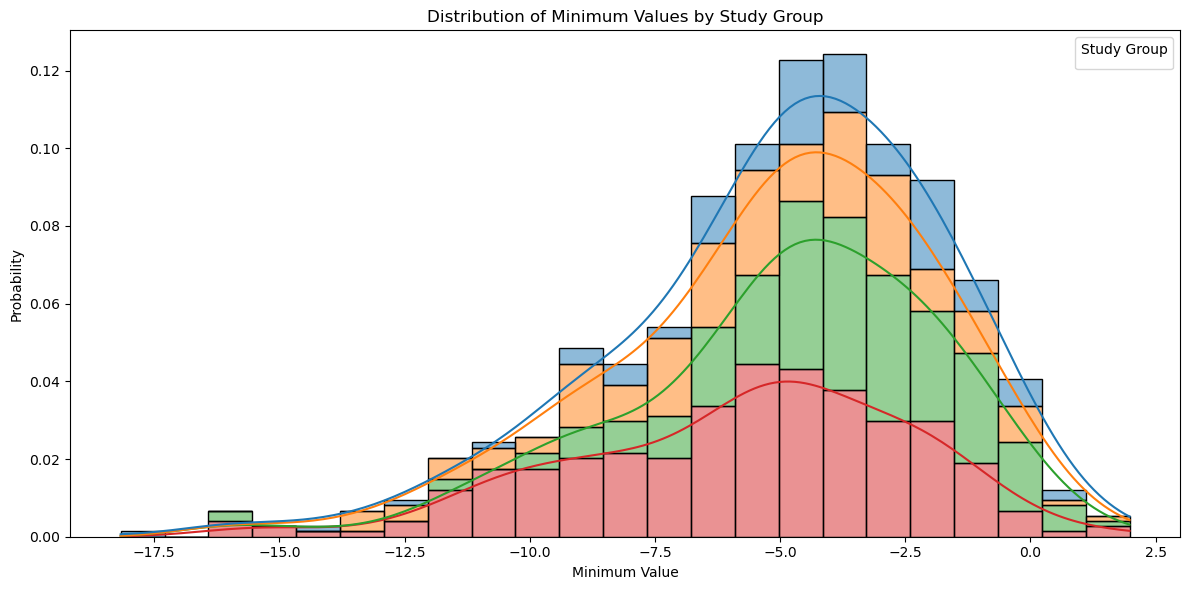

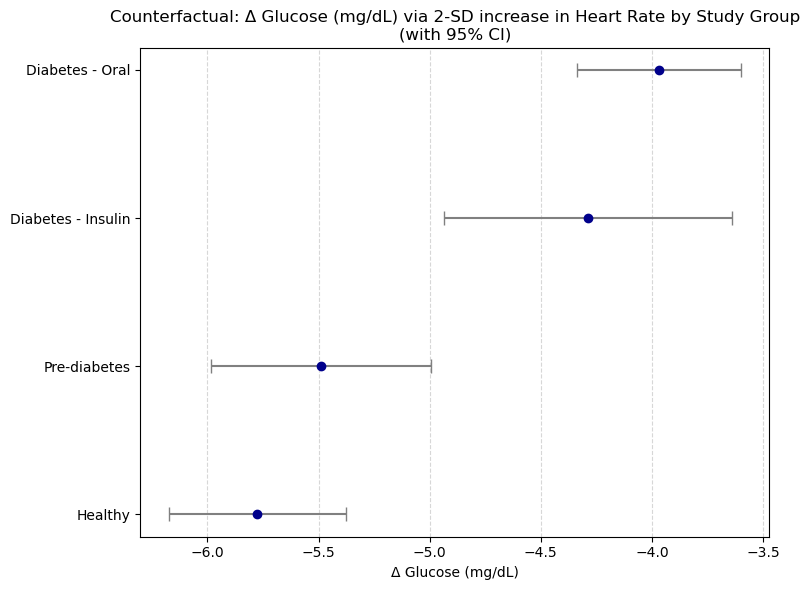

In [15]:
# Merge min_values with study group information
# df_min_values = pd.DataFrame(min_values, columns=['min_value'])
# df_min_values['participant_id'] = df_min_values.index
# df_min_values = df_min_values.merge(clinical_state, on='participant_id', how='left')
# df_min_values = df_min_values.set_index('participant_id')

df_min_values = pd.DataFrame(min_values, columns=['min_value'])
df_min_values['participant_id'] = df_min_values.index
df_min_values = df_min_values.reset_index(drop=True)

# make sure participant_id is only a column, not an index
#clinical_state = clinical_state.reset_index()

df_min_values = df_min_values.merge(clinical_state, on='participant_id', how='left')
df_min_values = df_min_values.set_index('participant_id')

# Plot the results
import matplotlib.pyplot as plt
import seaborn as sns
# plt.figure(figsize=(12, 6))
# sns.barplot(x=df_min_values.index, y='min_value', hue='study_group', data=df_min_values)
# plt.title('Minimum Values per Participant by Study Group')
# plt.xlabel('Participant ID')
# plt.ylabel('Minimum Value')
# plt.xticks(rotation=45)
# plt.legend(title='Study Group')
# plt.tight_layout()
# plt.show()

# Plot as distribution colored by study group - normalize the y axis
plt.figure(figsize=(12, 6))
sns.histplot(
    data=df_min_values,
    x='min_value',
    hue='study_group',
    multiple='stack',
    kde=True,
    stat='probability'  # This makes the y-axis a probability distribution
)
plt.title('Distribution of Minimum Values by Study Group')
plt.xlabel('Minimum Value')
plt.ylabel('Probability')
plt.legend(title='Study Group')
plt.tight_layout()
plt.show()


# Plot average effect and CI (or standard error) for each study group using df_min_values
# Order the study groups by their average minimum value
# Have it renamed (Healthy, Pre-diabetes, Diabetes - Oral, Diabetes - Insulin)
df_min_values['study_group'] = df_min_values['study_group'].replace({
    'healthy': 'Healthy',
    'pre_diabetes_lifestyle_controlled': 'Pre-diabetes',
    'oral_medication_and_or_non_insulin_injectable_medication_controlled': 'Diabetes - Oral',
    'insulin_dependent': 'Diabetes - Insulin'
})

# ['insulin_dependent' 'pre_diabetes_lifestyle_controlled'
#  'oral_medication_and_or_non_insulin_injectable_medication_controlled'
#  'healthy']

# Calculate mean and confidence intervals for each study group
import scipy.stats as stats

group_stats = df_min_values.groupby('study_group')['min_value'].agg(['mean', 'count', 'std'])
group_stats['sem'] = group_stats['std'] / group_stats['count']**0.5
group_stats['ci_lower'] = group_stats['mean'] - 1.96 * group_stats['sem']
group_stats['ci_upper'] = group_stats['mean'] + 1.96 * group_stats['sem']
group_stats = group_stats.sort_values('mean')

# Forest plot
plt.figure(figsize=(8, 6))
y_pos = range(len(group_stats))
plt.errorbar(group_stats['mean'], y_pos, xerr=[group_stats['mean']-group_stats['ci_lower'], group_stats['ci_upper']-group_stats['mean']],
             fmt='o', color='darkblue', ecolor='gray', capsize=5)
plt.yticks(y_pos, group_stats.index)
plt.xlabel('Δ Glucose (mg/dL)')
plt.title('Counterfactual: Δ Glucose (mg/dL) via 2-SD increase in Heart Rate by Study Group\n(with 95% CI)')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

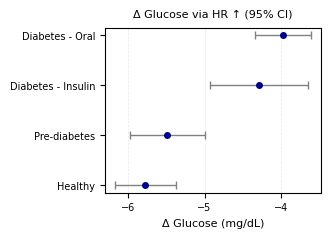

In [16]:
# More compact forest plot for figure sub-panel
plt.figure(figsize=(3.5, 2.5))  # smaller figure size

y_pos = range(len(group_stats))
plt.errorbar(
    group_stats['mean'], y_pos,
    xerr=[group_stats['mean'] - group_stats['ci_lower'],
          group_stats['ci_upper'] - group_stats['mean']],
    fmt='o', color='darkblue', ecolor='gray', capsize=3, markersize=4, linewidth=1
)

# Cleaner axis labels
plt.yticks(y_pos, group_stats.index, fontsize=7)
plt.xticks(fontsize=7)
plt.xlabel('Δ Glucose (mg/dL)', fontsize=8)

# Remove or shorten the title (since this is a sub-panel)
# plt.title('Counterfactual Δ Glucose by Study Group', fontsize=8)

# Optional: annotate instead of long title
plt.text(0.5, 1.05, "Δ Glucose via HR ↑ (95% CI)",
         fontsize=8, ha='center', va='bottom', transform=plt.gca().transAxes)

plt.grid(axis='x', linestyle='--', alpha=0.3, linewidth=0.5)
plt.tight_layout()
plt.show()


In [22]:
import matplotlib as mpl
import matplotlib.pyplot as plt

# --- Global quality settings ---
mpl.rcParams.update({
    # sizes in points (pt)
    "font.size": 7,                # base text (6–8 pt for subpanels)
    "axes.labelsize": 7,
    "xtick.labelsize": 6,
    "ytick.labelsize": 6,
    "legend.fontsize": 6,
    "lines.linewidth": 1.0,
    "lines.markersize": 4,
    "errorbar.capsize": 2.5,

    # layout & spines
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.grid": True,
    "grid.linestyle": "--",
    "grid.alpha": 0.3,
    "grid.linewidth": 0.5,

    # fonts & embedding (good for Illustrator/PowerPoint/Adobe)
    "font.family": "DejaVu Sans",      # or "Arial"/"Helvetica" if available
    "pdf.fonttype": 42,                 # embed TrueType
    "ps.fonttype": 42,

    # make math text consistent with font (optional)
    "mathtext.default": "regular",
})

# --- Figure at final print size ---
width_in = 3.4   # ~ single-column width
#height_in = 2.2  # keep compact for subpanel
height_in = 1.2
fig, ax = plt.subplots(figsize=(width_in, height_in), constrained_layout=True)

# --- Forest plot ---
y_pos = range(len(group_stats))
xerr = [group_stats['mean'] - group_stats['ci_lower'],
        group_stats['ci_upper'] - group_stats['mean']]

ax.errorbar(group_stats['mean'], y_pos, xerr=xerr,
            fmt='o', color='black', ecolor='0.5', linewidth=1)

ax.set_yticks(list(y_pos), labels=list(group_stats.index))
ax.set_xlabel('Δ Glucose (mg/dL)')
ax.set_ylabel("")  # keep minimal
ax.grid(axis='x')
ax.set_axisbelow(True)

# optional: panel letter
#ax.text(0.0, 1.02, "b", transform=ax.transAxes, weight="bold", fontsize=8, va="bottom")

# optional: tighten x-lims a bit around your data
# pad = 0.2
# xmin = (group_stats['ci_lower'].min()) - pad
# xmax = (group_stats['ci_upper'].max()) + pad
# ax.set_xlim(xmin, xmax)

# --- Save: vector preferred; raster fallback ---
fig.savefig("./figures/forest_counterfactual_HR.pdf", bbox_inches="tight", transparent=True)
fig.savefig("./figures/forest_counterfactual_HR.svg", bbox_inches="tight", transparent=True)
fig.savefig("./figures/forest_counterfactual_HR.png", dpi=600, bbox_inches="tight", transparent=True)

plt.close(fig)
